# 003. XGBoost 

This notebook trains and evaluates an XGBoost model to predict the duration of Supreme Court cases (in days) from oral argument to decision.

The process involves:
1.  **Loading and Setup**: Importing libraries and the custom `XGBoostModelTrainer`.
2.  **Feature Engineering**: Renaming, cleaning, and categorizing features from the SCDB dataset.
3.  **Leakage Control**: Carefully creating distinct feature sets to prevent data leakage and establish realistic performance baselines, but also considering another aproach not focused on prediction but rather analysis of past events.
4.  **Model Training**: Using the `XGBoostModelTrainer` to train models on different feature sets.
5.  **Hyperparameter Optimization**: Employing Optuna to find the optimal XGBoost parameters.
6.  **Results & XAI**: Preparing for the final analysis and explanation of the model's behavior.

### Table of Contents 

- [003. XGBoost](#003-xgboost)
  - [1. Loading the dataset, setting up the trainere](#1-loading-the-dataset-setting-up-the-trainere)
  - [2. Variable documentation](#2-variable-documentation)
  - [3. Mapping names of the model and grouping features](#3-mapping-names-of-the-model-and-grouping-features)
  - [4. Final data preparation for modelling](#4-final-data-preparation-for-modelling)
    - [Check for uncategorized features](#check-for-uncategorized-features)
  - [5. Modelling](#5-modelling)
  - [6. Loading the model / models from saved folders / files](#6-loading-the-model--models-from-saved-folders--files)
  - [7. Results](#7-results)

In [20]:
## TOC generation code:
# import sys
# import os

# # Add project root to sys.path
# notebook_dir = os.getcwd() 
# project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

# # Import TOC generator function
# from src.toc_generator import generate_toc_from_jupyter_notebook

# target_notebook_path = "003_XGB_XAI.ipynb" 

# toc_markdown = generate_toc_from_jupyter_notebook(target_notebook_path)

## 1. Loading the dataset, setting up the trainere

In this part we read the processed dataset. Then we import the XGBoostModelTrainer class from custom train_model.py script located in src folder. An instance (test) of this trainer is created with CUDA enabled, which will automatically use the GPU if available to speed up training. We also set up directories for saving models and plots.

In [24]:
# Libraries
import os
import sys
import random

import pandas as pd
import numpy as np

In [22]:
SEED = 420 # Choose seed
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
df = pd.read_csv(r'..\data\processed\scdb_processed_final.csv')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ---------------------------------------------

# Import .py xgboost trainer 
from src.train_model import XGBoostModelTrainer, load_model_for_xai

# Initialize trainer with CUDA support - later on will be reapplied
trainer = XGBoostModelTrainer(
    output_dir="../models",
    plot_dir="../plots", 
    enable_cuda=True,      # Automatically detects and uses GPU if available
    random_state=420,
    organize_by_model=True # Creates separate folders for each model
)

# ? what 4? 4 GPUS? 
print(f"Trainer initialized. Using device: {trainer.device_info['device_name'].upper()}") 

# Store all results for final comparison 
all_results = {}

CUDA detected: 4 GPU(s) available


## 2. Variable documentation

Feature documentation done with html as it is not being marked as part of outline in VS Code.

Feature documentation is crucial for understanding the dataset and ensuring that the model is trained on the correct features. The following variables are used in this notebook:


<h3>Feature Documentation</h3>

<h4>Temporal Features</h4>

<h5><code>month_of_argument</code></h5>
Month (1-12) when oral arguments were held.
<ul>
<li>Earlier months (Oct-Dec) = beginning of term</li>
<li>Later months (Apr-Jun) = end of term rush</li>
<li>May indicate workload patterns</li>
</ul>

<h5><code>month_of_decision</code></h5>
Month (1-12) when the decision was announced.
<ul>
<li>June decisions often rushed (end of term)</li>
<li>May affect deliberation quality/time</li>
</ul>

<h5><code>year_of_decision</code></h5>
Calendar year of the decision.
<ul>
<li>Captures temporal trends in court efficiency</li>
<li>May correlate with historical events/court composition</li>
</ul>

<h5><code>days_term_start_to_argument</code></h5>
Days from term start (Oct 1) to oral argument.
<ul>
<li>Early term arguments may have more deliberation time</li>
<li>Late term arguments face deadline pressure</li>
</ul>

<h5><code>days_term_start_to_decision</code></h5>
Days from term start (Oct 1) to decision.
<ul>
<li>Measures when in the term cycle decision occurs</li>
<li>Later decisions may be more complex/contentious</li>
</ul>

<h5><code>is_argument_late_in_term</code></h5>
Binary flag: 1 if argued in April or later.
<ul>
<li>Late arguments have less time before term ends</li>
<li>May indicate expedited or important cases</li>
</ul>

<h5><code>is_decision_late_in_term</code></h5>
Binary flag: 1 if decided in May or later.
<ul>
<li>Captures "June rush" effect</li>
<li>May indicate complex/divided cases</li>
</ul>

<h4>Court Structure Features</h4>

<h5><code>chief_justice_code</code></h5>
Numeric code identifying the Chief Justice.
<ul>
<li>Different chiefs may have different management styles</li>
<li>Affects court efficiency and deliberation pace</li>
</ul>

<h5><code>natural_court_period</code></h5>
Code for stable membership periods.
<ul>
<li>New justices may slow deliberations</li>
<li>Established courts may work more efficiently</li>
</ul>

<h5><code>court_term_year</code></h5>
Supreme Court term year (Oct-June).
<ul>
<li>Historical context for the case</li>
<li>Captures era-specific patterns</li>
</ul>

<h4>Case Origin and Source</h4>

<h5><code>case_origin_type</code></h5>
Simplified grouping of originating court:
<ul>
<li>'Federal': Federal district/circuit courts</li>
<li>'State': State courts</li>
<li>'Other': Territorial, unknown, special</li>
</ul>

<h5><code>case_source_type</code></h5>
Simplified grouping of court directly reviewed:
<ul>
<li>'Federal': Federal courts</li>
<li>'State': State courts  </li>
<li>'Other': Special jurisdictions</li>
</ul>

<h4>Case Type and Jurisdiction</h4>

<h5><code>case_docket_type</code></h5>
Type of Supreme Court docket:
<ul>
<li>'Merits/Other': Standard argued cases</li>
<li>'Special Jurisdiction': Original/Miscellaneous</li>
</ul>

<h5><code>jurisdiction_type</code></h5>
How case reached Supreme Court:
<ul>
<li>'Discretionary': Certiorari (court chooses)</li>
<li>'Mandatory': Appeal/Original (must hear)</li>
<li>'Other': Writs, procedural, unknown</li>
</ul>

<h5><code>cert_reason_category</code></h5>
Grouped reasons for granting certiorari:
<ul>
<li>'Substantive Reasons': Important Q, conflicts</li>
<li>'Procedural/Administrative': No reason, N/A</li>
<li>'Other': Unknown, other reasons</li>
</ul>

<h4>Legal Issues</h4>

<h5><code>specific_legal_issue_code</code></h5>
Detailed numeric code for the specific legal issue.
<ul>
<li>High cardinality (many unique values)</li>
<li>More granular than broad issue area</li>
</ul>

<h5><code>broad_issue_area</code></h5>
Major subject matter categories:
<ul>
<li>'Economic Activity': Business, commerce</li>
<li>'Criminal Procedure': Rights of accused</li>
<li>'Civil Rights': Discrimination, voting</li>
<li>'Judicial Power': Court jurisdiction</li>
<li>'First Amendment': Speech, religion</li>
<li>'Other Constitutional': Due process, federalism</li>
<li>'Other Non-Constitutional': Unions, tax, etc.</li>
</ul>

<h5><code>law_type_category</code></h5>
Type of law being interpreted:
<ul>
<li>'Constitutional': Constitution/Amendments</li>
<li>'Statutory': Federal statutes</li>
<li>'Other/Unknown': Rules, state law, unclear</li>
</ul>

<h5><code>supplemental_law_code</code></h5>
Detailed code for specific law/statute.
<ul>
<li>Supplements law_type with specifics</li>
<li>High cardinality categorical</li>
</ul>

<h4>Party Configuration</h4>

<h5><code>petitioner_type</code></h5>
Simplified petitioner (appellant) category:
<ul>
<li>'Government': US/State/Local govt & agencies</li>
<li>'Private Entities': Individuals, business</li>
<li>'Other/Unknown': Unclear or special parties</li>
</ul>

<h5><code>respondent_type</code></h5>
Simplified respondent (appellee) category:
<ul>
<li>Same categories as petitioner_type</li>
<li>Captures party dynamics</li>
</ul>

<h5><code>is_govt_vs_business_case</code></h5>
Binary: 1 if government entity vs business.
<ul>
<li>May have different deliberation patterns</li>
<li>Captures David vs Goliath dynamics</li>
</ul>

<h5><code>is_individual_vs_govt_case</code></h5>
Binary: 1 if individual vs government.
<ul>
<li>Often civil rights/liberties cases</li>
<li>May require careful deliberation</li>
</ul>

<h5><code>is_state_vs_state_case</code></h5>
Binary: 1 if state government vs state government.
<ul>
<li>Original jurisdiction cases</li>
<li>Often boundary/water rights disputes</li>
</ul>

<h4>Lower Court Information</h4>

<h5><code>lower_court_disagreement</code></h5>
Binary: 1 if explicit lower court conflict.
<ul>
<li>Major reason for Supreme Court review</li>
<li>May require more deliberation to resolve</li>
</ul>

<h5><code>lower_court_ideological_direction</code></h5>
Lower court decision ideology:
<ul>
<li>1: Conservative</li>
<li>2: Liberal  </li>
<li>3: Unspecifiable/Missing</li>
</ul>

<h5><code>lower_court_disposition_type</code></h5>
How lower court decided:
<ul>
<li>'Affirmed': Upheld lower ruling</li>
<li>'Reversed/Modified': Changed ruling</li>
<li>'Other/Unknown': Procedural, unclear</li>
</ul>

<h5><code>lower_court_disagree_ideology</code></h5>
Interaction of disagreement and ideology:
<ul>
<li>'LC_Agree_Conservative': No conflict, conservative</li>
<li>'LC_Agree_Liberal': No conflict, liberal</li>
<li>'LC_Disagree_Conservative': Conflict, conservative</li>
<li>'LC_Disagree_Liberal': Conflict, liberal</li>
<li>'LC_Unspec/Other': Unclear</li>
</ul>

<h4>Case Complexity Indicators</h4>

<h5><code>consolidated_dockets_count</code></h5>
Number of dockets consolidated in this case.
<ul>
<li>Higher = more complex (multiple related cases)</li>
<li>May require longer deliberation</li>
</ul>

<h5><code>case_had_reargument</code></h5>
Binary: 1 if case was reargued.
<ul>
<li>Indicates initial arguments insufficient</li>
<li>Strong complexity/difficulty signal</li>
</ul>

<h5><code>complexity_score_consolidated_disagree</code></h5>
Interaction: dockets_count × lower_court_disagreement.
<ul>
<li>Captures compounded complexity</li>
<li>High values = consolidated cases with conflicts</li>
</ul>

<h5><code>three_judge_district_court</code></h5>
Binary: 1 if from 3-judge district court.
<ul>
<li>Special federal court panels</li>
<li>Often important constitutional cases</li>
</ul>

<h4>Specialized Features</h4>

<h5><code>is_admin_economic_case</code></h5>
Binary: 1 if administrative agency + economic issue.
<ul>
<li>Regulatory/business intersection</li>
<li>May have specialized complexity</li>
</ul>

<h5><code>is_federal_circuit_conflict</code></h5>
Binary: 1 if federal circuit court with conflict.
<ul>
<li>Circuit splits are key cert reason</li>
<li>Requires harmonizing precedents</li>
</ul>

<h4>Interaction Features</h4>

<h5><code>issue_jurisdiction_interaction</code></h5>
Concatenated issue area + jurisdiction path.
<ul>
<li>Captures if certain issues via certain paths have distinct duration patterns</li>
</ul>

<h5><code>three_judge_issue_interaction</code></h5>
Concatenated issue area + three-judge flag.
<ul>
<li>Tests if 3-judge court effect varies by issue</li>
</ul>

<h4>Target Variable</h4>

<h5><code>case_duration_days</code></h5>
TARGET VARIABLE: Days from argument to decision.
<ul>
<li>What we're predicting</li>
<li>Measures deliberation time</li>
</ul>

<h4>Missing Value Indicators</h4>

<h5><code>lower_court_disagree_was_missing</code></h5>
Binary: 1 if lcDisagreement was originally missing.
<ul>
<li>Allows model to learn from missingness pattern</li>
<li>Missing may indicate certain case types</li>
</ul>

<h5><code>three_judge_info_was_missing</code></h5>
Binary: 1 if threeJudgeFdc was originally missing.
<ul>
<li>Captures data quality/availability patterns</li>
</ul>

<h4>Derived Features</h4>

<h5><code>decision_timing_category</code></h5>
Binned version of duration_days.
<ul>
<li>Could be used for classification instead of regression</li>
<li>Categories like 'Quick', 'Normal', 'Slow'</li>
</ul>

## 3. Mapping names of the model and grouping features

The raw dataset uses column names that are not easily recognizable (e.g., `lcDisagreement`, `threeJudgeFdc`). To improve readability, we will first map these to more recognizible names (e.g., `lower_court_disagreement`, `three_judge_district_court`).

In [6]:
# Create a mapping dictionary for cleaner column names
feature_name_mapping = {
    # Temporal Features
    'argument_month': 'month_of_argument',
    'decision_month': 'month_of_decision', 
    'decision_year': 'year_of_decision',
    'days_from_term_start_to_argument': 'days_term_start_to_argument',
    'days_from_term_start_to_decision': 'days_term_start_to_decision',
    'is_late_term_argument': 'is_argument_late_in_term',
    'is_late_term_decision': 'is_decision_late_in_term',
    
    # Court Structure Features
    'chief': 'chief_justice_sname',
    'naturalCourt': 'natural_court_period',
    'term': 'court_term_year',
    
    # Case Origin and Source
    'caseOrigin_group': 'case_origin_type',
    'caseSource_group': 'case_source_type',
    
    # Case Type and Jurisdiction
    'docket_category': 'case_docket_type',
    'jurisdiction_group': 'jurisdiction_type',
    'certReason_group': 'cert_reason_category',
    
    # Legal Issues
    'issue': 'specific_legal_issue_code',
    'issueArea_name': 'broad_issue_area',
    'lawType_group': 'law_type_category',
    'lawSupp': 'supplemental_law_code',
    
    # Party Configuration
    'petitioner_group': 'petitioner_type',
    'respondent_group': 'respondent_type',
    'is_Govt_vs_Business': 'is_govt_vs_business_case',
    'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
    'is_State_vs_State': 'is_state_vs_state_case',
    
    # Lower Court Information
    'lcDisagreement': 'lower_court_disagreement',
    'lcDispositionDirection': 'lower_court_ideological_direction',
    'lcDisposition_group': 'lower_court_disposition_type',
    'lc_disagree_direction': 'lower_court_disagree_ideology',
    
    # Case Complexity Indicators
    'num_dockets_in_case': 'consolidated_dockets_count',
    'had_reargument': 'case_had_reargument',
    'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
    'threeJudgeFdc': 'three_judge_district_court',
    
    # Specialized Features
    'is_AdminAction_x_Economic': 'is_admin_economic_case',
    'is_FedCirc_Conflict': 'is_federal_circuit_conflict',
    
    # Interaction Features
    'issue_x_jurisdiction': 'issue_jurisdiction_interaction',
    'threeJudge_x_issue': 'three_judge_issue_interaction',
    
    # Target Variable
    'duration_days': 'case_duration_days',
    
    # Missing Value Indicators
    'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
    'threeJudgeFdc_is_missing': 'three_judge_info_was_missing',
    
    # Derived Features
    'decision_timing_bin': 'decision_timing_category'
}

# Apply the mapping to rename columns
df = df.rename(columns=feature_name_mapping)
print(df.columns.tolist())
#print(df.shape[1])

['month_of_argument', 'case_origin_type', 'case_source_type', 'cert_reason_category', 'chief_justice_sname', 'complexity_score_consolidated_disagree', 'days_term_start_to_argument', 'days_term_start_to_decision', 'month_of_decision', 'year_of_decision', 'case_docket_type', 'case_had_reargument', 'is_admin_economic_case', 'is_federal_circuit_conflict', 'is_govt_vs_business_case', 'is_individual_vs_govt_case', 'is_state_vs_state_case', 'is_argument_late_in_term', 'is_decision_late_in_term', 'specific_legal_issue_code', 'broad_issue_area', 'issue_jurisdiction_interaction', 'jurisdiction_type', 'supplemental_law_code', 'law_type_category', 'lower_court_disagreement', 'lower_court_ideological_direction', 'lower_court_disposition_type', 'lower_court_disagree_ideology', 'natural_court_period', 'consolidated_dockets_count', 'petitioner_type', 'respondent_type', 'court_term_year', 'three_judge_district_court', 'three_judge_issue_interaction', 'case_duration_days', 'lower_court_disagree_was_miss

For easier analysis and grouped feature importance plots later on (in the XAI phase), we are grouping the renamed features into logical categories.

In [7]:
print("=== FEATURE CATEGORIES AND COUNTS ===\n")

feature_categories = {
    'Temporal Features': ['month_of_argument', 'month_of_decision', 'year_of_decision', 
                            'days_term_start_to_argument', 'days_term_start_to_decision',
                            'is_argument_late_in_term', 'is_decision_late_in_term'],
    'Court Structure': ['chief_justice_sname', 'natural_court_period', 'court_term_year'],
    'Case Origin/Source': ['case_origin_type', 'case_source_type'],
    'Case Type/Jurisdiction': ['case_docket_type', 'jurisdiction_type', 'cert_reason_category'],
    'Legal Issues': ['specific_legal_issue_code', 'broad_issue_area', 'law_type_category', 'supplemental_law_code'],
    'Party Configuration': ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
                           'is_individual_vs_govt_case', 'is_state_vs_state_case'],
    'Lower Court Info': ['lower_court_disagreement', 'lower_court_ideological_direction',
                        'lower_court_disposition_type', 'lower_court_disagree_ideology'],
    'Complexity Indicators': ['consolidated_dockets_count', 'case_had_reargument',
                             'complexity_score_consolidated_disagree', 'three_judge_district_court'],
    'Specialized Features': ['is_admin_economic_case', 'is_federal_circuit_conflict'],
    'Interaction Features': ['issue_jurisdiction_interaction', 'three_judge_issue_interaction'],
    'Missing Indicators': ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'],
    'Target/Derived': ['case_duration_days', 'decision_timing_category']
}

for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")
    
print(f"\nTotal features: {sum(len(f) for f in feature_categories.values())}")

=== FEATURE CATEGORIES AND COUNTS ===

Temporal Features: 7 features
Court Structure: 3 features
Case Origin/Source: 2 features
Case Type/Jurisdiction: 3 features
Legal Issues: 4 features
Party Configuration: 5 features
Lower Court Info: 4 features
Complexity Indicators: 4 features
Specialized Features: 2 features
Interaction Features: 2 features
Missing Indicators: 2 features
Target/Derived: 2 features

Total features: 40


## 4. Final data preparation for modelling

In this section the final cleaning and preparation of the data before it's fed into the model is performed. 

Key steps include:
- **Dropping leaky or problematic features**: Removing columns that wouldn't be available at prediction time or that are direct derivatives of the target.
- **Managing cardinality**: Grouping rare categorical values to prevent overfitting.
- **Defining feature types**: Explicitly identifying numerical, binary, and categorical features for the preprocessing pipeline.
- **Creating distinct feature sets**: Building `basic`, `leakage_controlled`, and `full_with_leakage` sets to properly evaluate the model's predictive power (with potential data leakage) and without data leakage.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# ========================================
# STEP 1: Apply Feature Renaming ( already done above, but kept for clarity)
# ========================================

print("=== STEP 1: Renaming Features ===")
df_renamed = df.rename(columns=feature_name_mapping)
print(f"Features renamed. New shape: {df_renamed.shape}")


# ========================================
# STEP 2: Handle Problematic Features
# ========================================

print("\n=== STEP 2: Handling Problematic Features ===")

# 2.1: Drop high-cardinality interaction features and clear leakage
features_to_drop = [
    'issue_jurisdiction_interaction',  # Too many unique combinations (hundreds)
    'three_judge_issue_interaction',   # Too many unique combinations
    'supplemental_law_code',           # Very high cardinality (100+ values), limited interpretability
    'case_had_reargument',             # STRONG LEAKAGE: only known AFTER initial arguments; excluded from each set
    'decision_timing_category'         # Derived from target variable
]

print(f"Dropping {len(features_to_drop)} problematic features...")
print("Reasons for dropping:")
print("  - issue_jurisdiction_interaction: High cardinality interaction")
print("  - three_judge_issue_interaction: High cardinality interaction")
print("  - supplemental_law_code: Too many unique values, hard to interpret")
print("  - case_had_reargument: Strong leakage - only known after arguments fail")
print("  - decision_timing_category: Directly derived from target")

df_cleaned = df_renamed.drop(columns=[f for f in features_to_drop if f in df_renamed.columns])
print(f"New shape after dropping: {df_cleaned.shape}")

# 2.2: Handle 'specific_legal_issue_code' - create frequency-based groups
print("\nGrouping rare legal issues...")
issue_counts = df_cleaned['specific_legal_issue_code'].value_counts()
rare_issues = issue_counts[issue_counts < 30].index  # Issues with less than 30 cases
df_cleaned['specific_legal_issue_grouped'] = df_cleaned['specific_legal_issue_code'].apply(
    lambda x: 'rare_issue' if x in rare_issues else str(x)
)
# Drop the original high-cardinality column
df_cleaned = df_cleaned.drop('specific_legal_issue_code', axis=1)
print(f"Created grouped issue feature with {df_cleaned['specific_legal_issue_grouped'].nunique()} categories")


# ========================================
# STEP 3: Separate Features by Type
# ========================================

print("\n=== STEP 3: Identifying Feature Types ===")

# Define numerical features (continuous values)
numerical_features = [
    'month_of_argument',
    'month_of_decision', 
    'year_of_decision',
    'days_term_start_to_argument',
    'days_term_start_to_decision',
    'natural_court_period',
    'court_term_year',
    'lower_court_disagreement',
    'lower_court_ideological_direction',
    'consolidated_dockets_count',
    'complexity_score_consolidated_disagree',
    'three_judge_district_court'
]

# Define binary features (0/1 flags)
binary_features = [
    'is_argument_late_in_term',
    'is_decision_late_in_term',
    'is_govt_vs_business_case',
    'is_individual_vs_govt_case',
    'is_state_vs_state_case',
    'is_admin_economic_case',
    'is_federal_circuit_conflict',
    'lower_court_disagree_was_missing',
    'three_judge_info_was_missing'
]

# Define categorical features (may need encoding)
categorical_features = [
    'case_origin_type',
    'case_source_type',
    'case_docket_type',
    'jurisdiction_type',
    'cert_reason_category',
    'broad_issue_area',
    'law_type_category',
    'petitioner_type',
    'respondent_type',
    'lower_court_disposition_type',
    'lower_court_disagree_ideology',
    'specific_legal_issue_grouped',  # Our new grouped feature
    'chief_justice_sname'  
]

# Filter definitions by columns existing in df_cleaned
numerical_features = [f for f in numerical_features if f in df_cleaned.columns]
binary_features = [f for f in binary_features if f in df_cleaned.columns]
categorical_features = [f for f in categorical_features if f in df_cleaned.columns]

# Ensure features are in at most one list
cat_set = set(categorical_features)
bin_set = set(binary_features)

temp_binary = []
for f in binary_features:
    if f not in cat_set:
        temp_binary.append(f)
binary_features = temp_binary
bin_set = set(binary_features)

temp_numerical = []
for f in numerical_features:
    if f not in cat_set and f not in bin_set:
        temp_numerical.append(f)
numerical_features = temp_numerical

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Binary features identified: {len(binary_features)}")
print(f"Categorical features identified: {len(categorical_features)}")


# ========================================
# STEP 4: Create Feature Sets for Modeling
# ========================================
print("\n=== STEP 4: Creating Feature Sets ===")

# Define clear leakage variables (information not available at prediction time)
clear_leakage_vars = [ # without the reargument as it is already dropped
    'days_term_start_to_decision',  # Requires knowing decision date
    'month_of_decision',             # Decision month unknown at argument time
    'year_of_decision',              # Decision year unknown at argument time
    'is_decision_late_in_term'       # Based on decision month
]

# Target variable (excluded from all feature sets)
model_input_exclusions = ['case_duration_days']

# --- 4.1: Basic Feature Set ---
# Core features that are most reliable and interpretable
basic_features = [
    # Temporal (known at argument time)
    'month_of_argument', 
    'days_term_start_to_argument',
    'is_argument_late_in_term',
    # Court
    'court_term_year', 
    'natural_court_period',
    'chief_justice_sname',
    # Case type
    'case_docket_type', 
    'jurisdiction_type', 
    'broad_issue_area',
    # Parties
    'petitioner_type', 
    'respondent_type',
    # Complexity
    'consolidated_dockets_count',
    # Lower court
    'lower_court_disagreement', 
    'lower_court_disposition_type'
]

basic_features_final = [f for f in basic_features if f in df_cleaned.columns]
print(f"\nBasic feature set includes core predictors known at argument time")
print(f"Basic features: {len(basic_features_final)} features")

# --- 4.2: Full Feature Set WITH Leakage ---
# All features except target - includes decision-time information
# This helps understand upper bound of predictive performance
full_features_with_leakage_final = [
    col for col in df_cleaned.columns if col not in model_input_exclusions
]
print(f"\nFull feature set includes ALL features (including leakage)")
print(f"Full with leakage: {len(full_features_with_leakage_final)} features")

# --- 4.3: Leakage-Controlled Feature Set ---
# All features except those with clear leakage
# This is the recommended set for actual prediction
leakage_controlled_features_final = [
    f for f in full_features_with_leakage_final
    if f not in clear_leakage_vars
]
print(f"\nLeakage-controlled set excludes decision-time information")
print(f"Leakage-controlled: {len(leakage_controlled_features_final)} features")

# Show what's being excluded as leakage
leakage_features_in_data = [f for f in clear_leakage_vars if f in full_features_with_leakage_final]
print(f"\nFeatures identified as leakage and excluded from controlled set:")
for feat in leakage_features_in_data:
    print(f"  - {feat}")


# ========================================
# STEP 5 & 6: Prepare Data and Configurations
# ========================================
print("\n=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===")

if 'case_duration_days' not in df_cleaned.columns:
    raise ValueError("'case_duration_days' target variable not found in df_cleaned.")
y = df_cleaned['case_duration_days']

# Using the three specifically requested feature sets
feature_sets_to_prepare = {
    "basic": basic_features_final,
    "full_with_leakage": full_features_with_leakage_final,
    "leakage_controlled": leakage_controlled_features_final
}

all_model_inputs = {}

for set_name, selected_features_list in feature_sets_to_prepare.items():
    print(f"\n--- Preparing for feature set: {set_name.upper()} ---")
    
    X_current = df_cleaned[selected_features_list].copy()
    print(f"X_{set_name} shape: {X_current.shape}")

    current_numerical_typed = [f for f in numerical_features if f in X_current.columns]
    current_binary_typed = [f for f in binary_features if f in X_current.columns]
    current_categorical_typed = [f for f in categorical_features if f in X_current.columns]
    
    # For XGBoost, numerical and binary can be treated the same
    current_numerical_for_trainer = current_numerical_typed + current_binary_typed
    current_categorical_for_trainer = current_categorical_typed
    
    # Sanity check
    trainer_features_set = set(current_numerical_for_trainer + current_categorical_for_trainer)
    x_current_set = set(X_current.columns)
    if trainer_features_set != x_current_set:
        print(f"Warning for set '{set_name}': Feature mismatch detected")
        missing_from_trainer = x_current_set - trainer_features_set
        if missing_from_trainer:
            print(f"  Missing from trainer config: {missing_from_trainer}")

    print(f"For XGBoostModelTrainer ({set_name} set):")
    print(f"  Numerical + Binary features: {len(current_numerical_for_trainer)}")
    print(f"  Categorical features: {len(current_categorical_for_trainer)}")

    all_model_inputs[set_name] = {
        'X': X_current,
        'y': y,
        'numerical_for_trainer': current_numerical_for_trainer,
        'categorical_for_trainer': current_categorical_for_trainer,
        'feature_list': selected_features_list 
    }

print(f"\nTarget variable statistics:")
print(f"  Mean duration: {y.mean():.1f} days")
print(f"  Median duration: {y.median():.1f} days")
print(f"  Std deviation: {y.std():.1f} days")
print(f"  Min: {y.min():.0f} days, Max: {y.max():.0f} days")


# ========================================
# STEP 7: Feature Importance Analysis Setup
# ========================================
print("\n=== STEP 7: Feature Analysis Preparation ===")

# Using leakage_controlled set for feature grouping (recommended for analysis)
if 'leakage_controlled' in all_model_inputs:
    selected_features_for_groups = all_model_inputs['leakage_controlled']['feature_list']

    feature_groups = {
        'Temporal': [f for f in ['month_of_argument', 'days_term_start_to_argument', 'is_argument_late_in_term'] 
                     if f in selected_features_for_groups],
        'Court Structure': [f for f in ['chief_justice_sname', 'natural_court_period', 'court_term_year'] 
                           if f in selected_features_for_groups],
        'Case Type': [f for f in ['case_docket_type', 'jurisdiction_type', 'cert_reason_category', 
                                 'case_origin_type', 'case_source_type'] 
                     if f in selected_features_for_groups],
        'Legal Issues': [f for f in ['broad_issue_area', 'law_type_category', 'specific_legal_issue_grouped'] 
                        if f in selected_features_for_groups],
        'Parties': [f for f in ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case', 
                               'is_individual_vs_govt_case', 'is_state_vs_state_case'] 
                   if f in selected_features_for_groups],
        'Lower Court': [f for f in ['lower_court_disagreement', 'lower_court_disposition_type', 
                                   'lower_court_ideological_direction', 'lower_court_disagree_ideology'] 
                       if f in selected_features_for_groups],
        'Complexity': [f for f in ['consolidated_dockets_count', 'complexity_score_consolidated_disagree', 
                                  'three_judge_district_court'] 
                      if f in selected_features_for_groups],
        'Missing Indicators': [f for f in ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'] 
                              if f in selected_features_for_groups],
        'Specialized': [f for f in ['is_admin_economic_case', 'is_federal_circuit_conflict'] 
                       if f in selected_features_for_groups]
    }
    
    # Remove empty groups
    feature_groups = {name: f_list for name, f_list in feature_groups.items() if f_list}

    print("\nFeature groups for importance analysis:")
    for group, features_in_group in feature_groups.items():
        print(f"  {group}: {len(features_in_group)} features")
        
    # Show feature distribution across sets
    print("\n=== Feature Set Comparison ===")
    print(f"Basic set: {len(all_model_inputs['basic']['feature_list'])} features")
    print(f"Leakage-controlled set: {len(all_model_inputs['leakage_controlled']['feature_list'])} features")
    print(f"Full with leakage set: {len(all_model_inputs['full_with_leakage']['feature_list'])} features")
    
    # Features only in full set (leakage features)
    leakage_only = set(all_model_inputs['full_with_leakage']['feature_list']) - set(all_model_inputs['leakage_controlled']['feature_list'])
    if leakage_only:
        print(f"\nLeakage features (only in full set): {leakage_only}")
    
    # Additional features in leakage-controlled vs basic
    additional_controlled = set(all_model_inputs['leakage_controlled']['feature_list']) - set(all_model_inputs['basic']['feature_list'])
    if additional_controlled:
        print(f"\nAdditional features in leakage-controlled vs basic:")
        for feat in sorted(additional_controlled):
            print(f"  - {feat}")


print("\n=== PREPROCESSING COMPLETE ===")
print("Ready for model training with three feature sets:")
print("1. 'basic': Core reliable features for baseline")
print("2. 'full_with_leakage': All features to understand upper bound")
print("3. 'leakage_controlled': Recommended for actual predictions")
print("\nall_model_inputs dictionary contains X, y, and feature configurations for each set.")

=== STEP 1: Renaming Features ===
Features renamed. New shape: (9534, 40)

=== STEP 2: Handling Problematic Features ===
Dropping 5 problematic features...
Reasons for dropping:
  - issue_jurisdiction_interaction: High cardinality interaction
  - three_judge_issue_interaction: High cardinality interaction
  - supplemental_law_code: Too many unique values, hard to interpret
  - case_had_reargument: Strong leakage - only known after arguments fail
  - decision_timing_category: Directly derived from target
New shape after dropping: (9534, 35)

Grouping rare legal issues...
Created grouped issue feature with 99 categories

=== STEP 3: Identifying Feature Types ===
Numerical features identified: 12
Binary features identified: 9
Categorical features identified: 13

=== STEP 4: Creating Feature Sets ===

Basic feature set includes core predictors known at argument time
Basic features: 14 features

Full feature set includes ALL features (including leakage)
Full with leakage: 34 features

Leaka

### Check for uncategorized features

In [9]:
# def get_variable_type(variable):
#     if hasattr(variable, 'dtype'):
#         if pd.api.types.is_numeric_dtype(variable):
#             if pd.api.types.is_bool_dtype(variable):
#                 return "boolean (numerical by dtype, often categorical)"
#             return "numerical"
#         elif pd.api.types.is_categorical_dtype(variable):
#             return "categorical (explicit)"
#         elif pd.api.types.is_object_dtype(variable) or \
#              pd.api.types.is_string_dtype(variable):
#             return "categorical (object/string)"
#         elif pd.api.types.is_datetime64_any_dtype(variable) or \
#              pd.api.types.is_timedelta64_dtype(variable):
#             return "datetime/timedelta"
#         else:
#             return f"other pandas dtype ({variable.dtype})"
#     else:
#         if isinstance(variable, (int, float, complex)):
#             return "numerical (basic type)"
#         elif isinstance(variable, str):
#             return "categorical (string basic type)"
#         elif isinstance(variable, bool):
#             return "boolean (basic type)"
#         else:
#             return "other basic type"
# # --- End of assumed pre-defined items ---


# # Get automated types for all columns in df_cleaned
# automated_column_types = {}
# for col_name in df_cleaned.columns:
#     automated_column_types[col_name] = get_variable_type(df_cleaned[col_name])

# # --- Identify Discrepancies ---
# discrepancy_list = {} # Using a dict to store more info: {col_name: reason}
# all_manually_listed_features = set(numerical_features + binary_features + categorical_features)

# # Check numerical features
# for col_name in numerical_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # A feature listed as numerical should ideally be 'numerical' or 'boolean (numerical by dtype, often categorical)'
#         if not (auto_type == "numerical" or auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'numerical', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'numerical', but Column NOT FOUND in DataFrame"

# # Check binary features
# for col_name in binary_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # Binary features are typically numeric (int/float for 0/1) or boolean
#         if not (auto_type == "numerical" or auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'binary', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'binary', but Column NOT FOUND in DataFrame"

# # Check categorical features
# for col_name in categorical_features:
#     if col_name in df_cleaned.columns:
#         auto_type = automated_column_types[col_name]
#         # Categorical can be explicit, object/string, or even boolean
#         if not (auto_type == "categorical (explicit)" or \
#                 auto_type == "categorical (object/string)" or \
#                 auto_type == "boolean (numerical by dtype, often categorical)"):
#             discrepancy_list[col_name] = (f"Manually 'categorical', "
#                                           f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")
#     else:
#         discrepancy_list[col_name] = "Manually 'categorical', but Column NOT FOUND in DataFrame"

# # Check for columns in DataFrame but not in any manual list (unclassified)
# for col_name in df_cleaned.columns:
#     if col_name not in all_manually_listed_features:
#         auto_type = automated_column_types[col_name]
#         discrepancy_list[col_name] = (f"Unclassified (not in manual lists), "
#                                       f"Auto '{auto_type}' (Dtype: {df_cleaned[col_name].dtype})")


# # --- Display Value Counts for Discrepant/Unclassified Columns; should only display the case duration days so our target variable ---
# print("\n--- Columns Requiring Manual Review (Discrepancies or Unclassified) ---")
# if not discrepancy_list:
#     print("No discrepancies found and all columns are classified!")
# else:
#     for col_name, reason in discrepancy_list.items():
#         print(f"\nColumn: '{col_name}'")
#         print(f"Reason for review: {reason}")
#         if col_name in df_cleaned.columns:
#             print(f"Actual Dtype in DataFrame: {df_cleaned[col_name].dtype}")
#             print("Value Counts (dropna=False to include NaNs):")
#             # Show more values if unique count is low, otherwise top N
#             if df_cleaned[col_name].nunique(dropna=False) <= 20:
#                  print(df_cleaned[col_name].value_counts(dropna=False))
#             else:
#                 print(df_cleaned[col_name].value_counts(dropna=False).head(10))
#                 if df_cleaned[col_name].nunique(dropna=False) > 10:
#                     print(f"... and {df_cleaned[col_name].nunique(dropna=False) - 10} more unique values.")
#             print("-" * 40)
#         else:
#             print("This column was not found in the DataFrame, so no value counts can be shown.")
#             print("-" * 40)

## 5. Modelling 

Once more trainer is set up, we can proceed with the modelling. The following steps will be taken:

We will now train XGBoost models using the three feature sets prepared earlier. For each feature set, we will run multiple scenarios to compare performance:
1.  **Baseline Model**: Trained with default hyperparameters to establish a performance baseline.
2.  **Optuna-Tuned Model**: Uses the Optuna library for advanced hyperparameter optimization to find the best-performing model.
3.  **Random Search Model**: A simpler hyperparameter search for comparison. -> currently not implemented, but can be added later. Solving issue of early stopping.
4. ... there are more scenarios that can be added later on.

The `XGBoostModelTrainer` class will handle the entire pipeline for each scenario, including training, cross-validation, evaluation, and saving all outputs (models, metadata, and plots). The results are stored for a final comparison.

PREPARING FEATURE SETS FOR MODELING
basic: 14 features prepared
leakage_controlled: 30 features prepared
full_with_leakage: 34 features prepared

DEFINING HYPERPARAMETER SEARCH SPACES
Optuna search space defined
Random search space defined (constrained)

STARTING XGBOOST MODEL TRAINING

RUNNING SCENARIOS FOR FEATURE SET: BASIC
Features: 14

--- SCENARIO 1: Baseline_basic ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_basic_baseline_v1
Model directory: ../models\scdb_duration_basic_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 7 numerical and 7 categorical features
Fitting preprocessor...
Preprocessing complete: 27 features

Training fina

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 40.8636
Optuna study saved: ../models\scdb_duration_basic_optuna_v1\scdb_duration_basic_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_basic_optuna_v1\scdb_duration_basic_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.0701
  Fold 2/5 - RMSE: 39.9256
  Fold 3/5 - RMSE: 42.7796
  Fold 4/5 - RMSE: 42.4780
  Fold 5/5 - RMSE: 41.1158
Advanced CV RMSE: 40.67 ± 2.07
Average best iteration: 593

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 664
  learning_rate: 0.011799180869139642
  max_depth: 10
  subsample: 0.95
  colsample_bytree: 0.6
  gamma: 0.663451649485986
  min_child_weight: 3
  reg_lambda: 0.4158792035493513
  reg_alpha: 0.010941103889822962
  early_stopping_rounds: 50

Tra

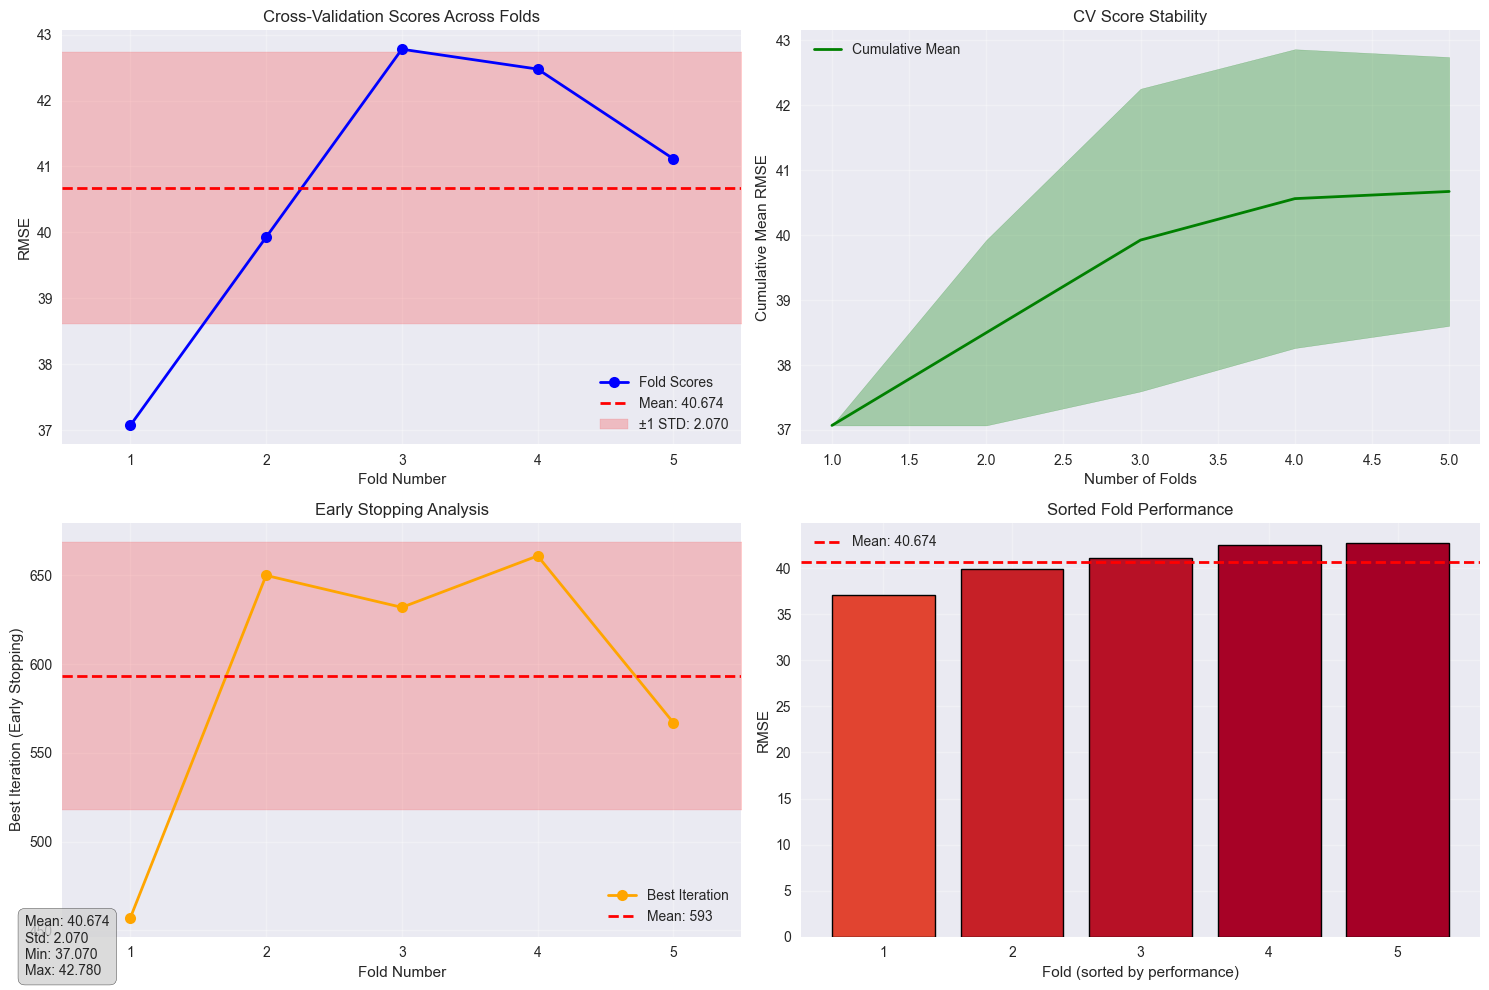

Creating training curve plots...


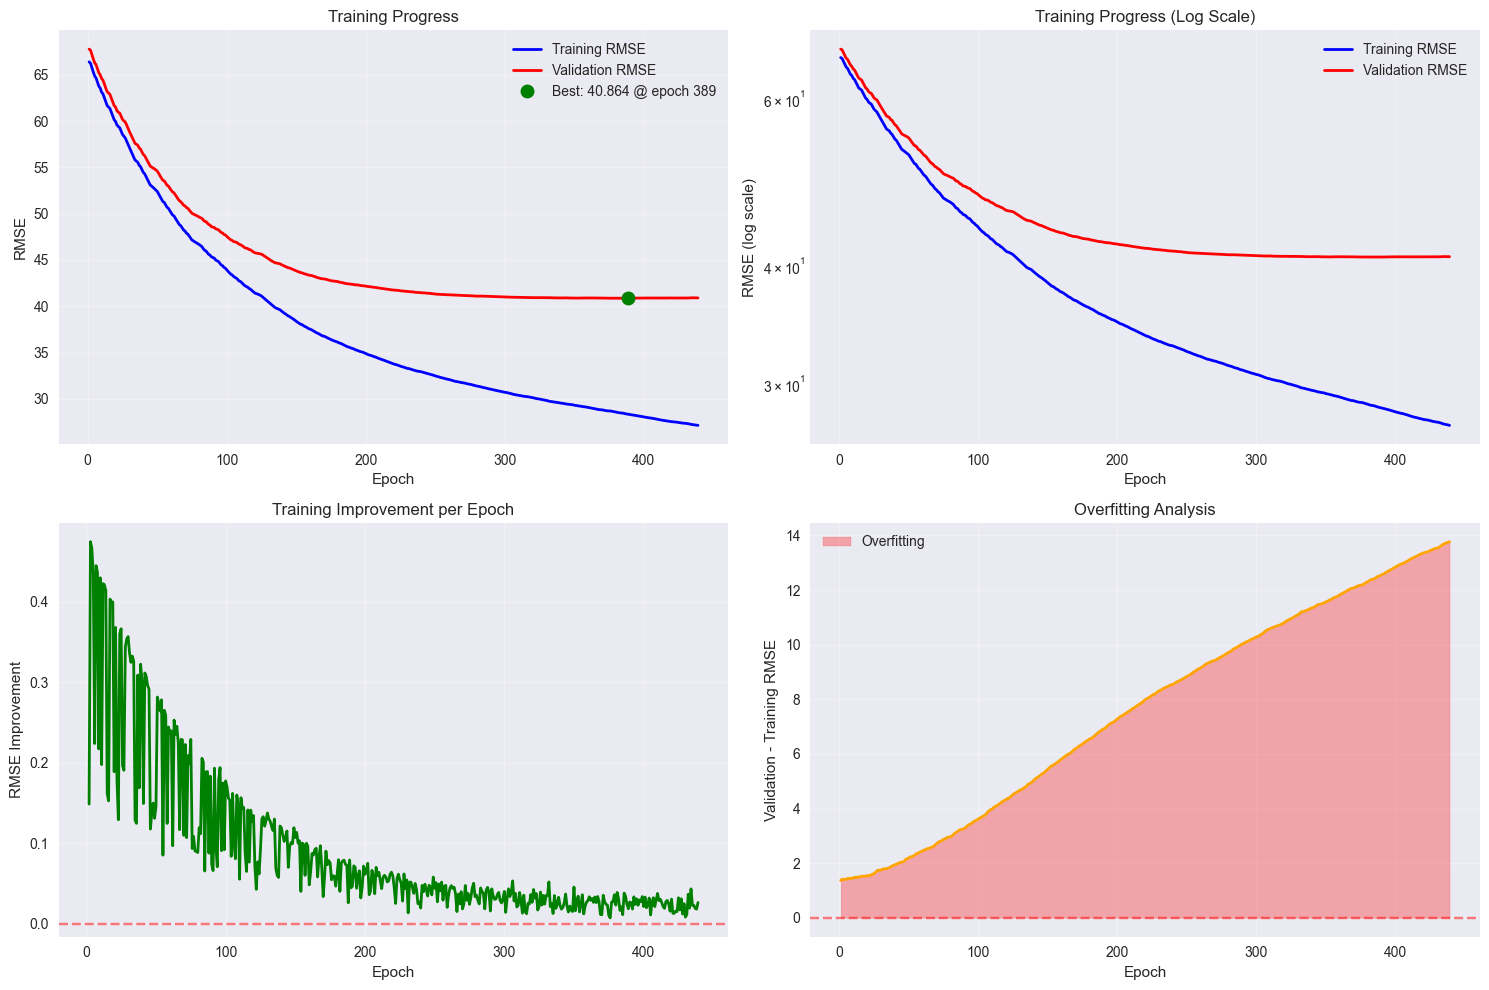


Training completed successfully!
Total time: 224.2s
Final test RMSE: 42.66 days
Advanced CV RMSE: 40.67 ± 2.07 days
Optuna optimization completed in 3.8m
Test RMSE: 42.66 days

RUNNING SCENARIOS FOR FEATURE SET: LEAKAGE_CONTROLLED
Features: 30

--- SCENARIO 1: Baseline_leakage_controlled ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_baseline_v1
Model directory: ../models\scdb_duration_leakage_controlled_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 17 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 98 features

Training final model with parameters:
  objective: reg:squarederror
 

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 39.4674
Optuna study saved: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 35.9399
  Fold 2/5 - RMSE: 39.7323
  Fold 3/5 - RMSE: 41.0466
  Fold 4/5 - RMSE: 42.3388
  Fold 5/5 - RMSE: 40.2052
Advanced CV RMSE: 39.85 ± 2.15
Average best iteration: 433

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1040
  learning_rate: 0.0174054120657072
  max_depth: 13
  subsample: 0.85
  colsample_bytree: 0.65
  gamma: 0.8776269118253281
  min_child_weight: 3
  reg_lambda: 0.11507277808810233
  reg_alpha:

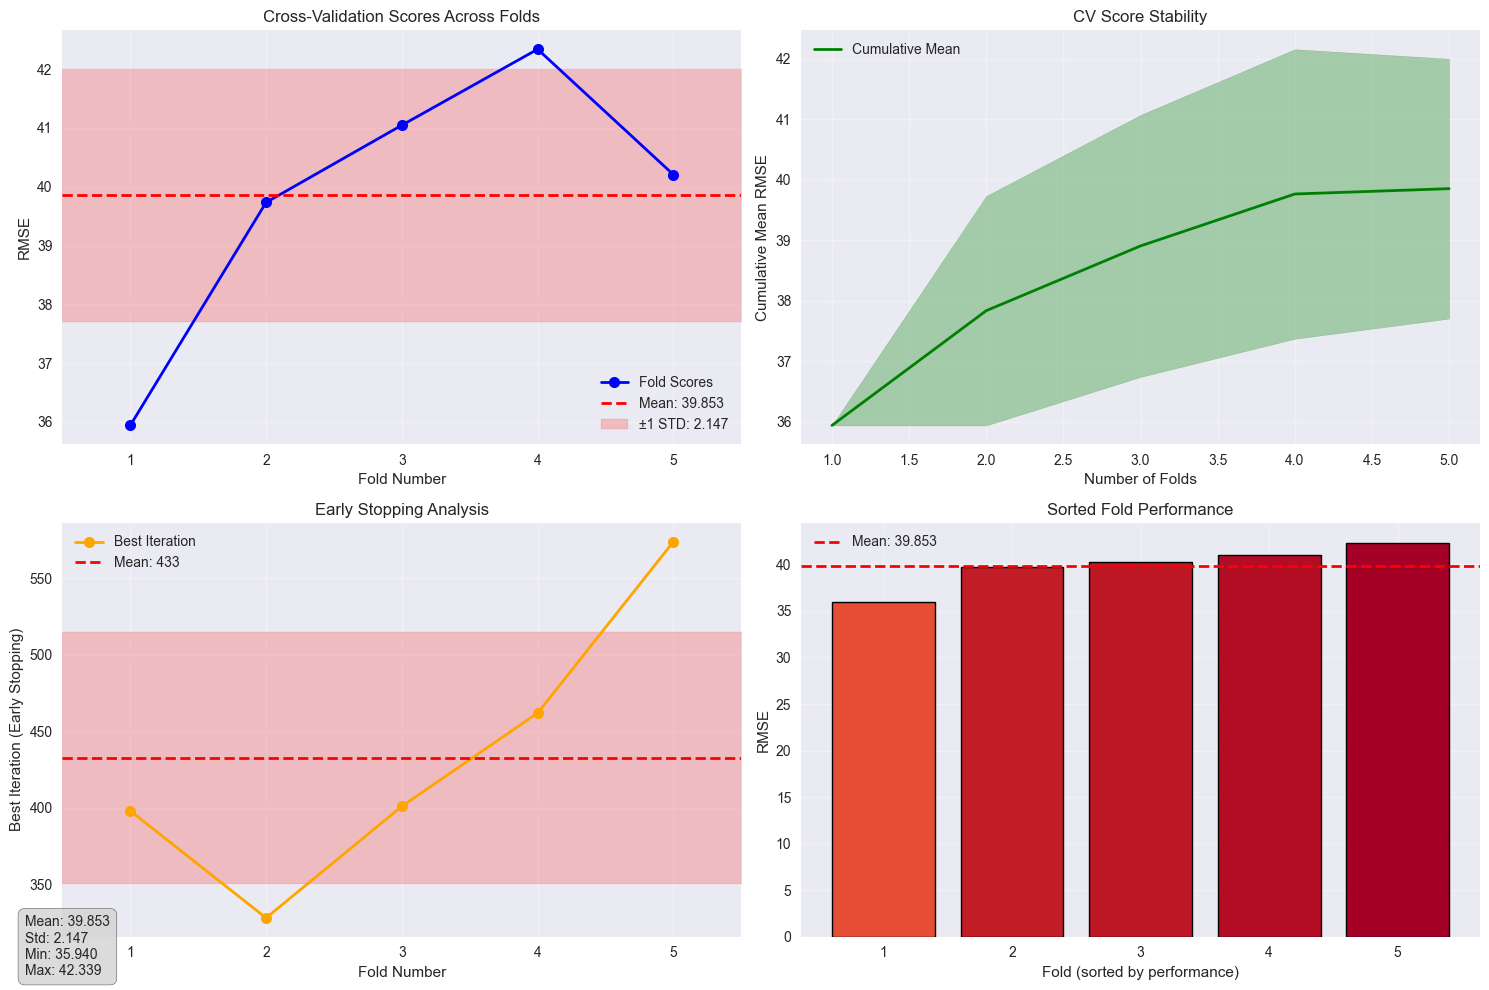

Creating training curve plots...


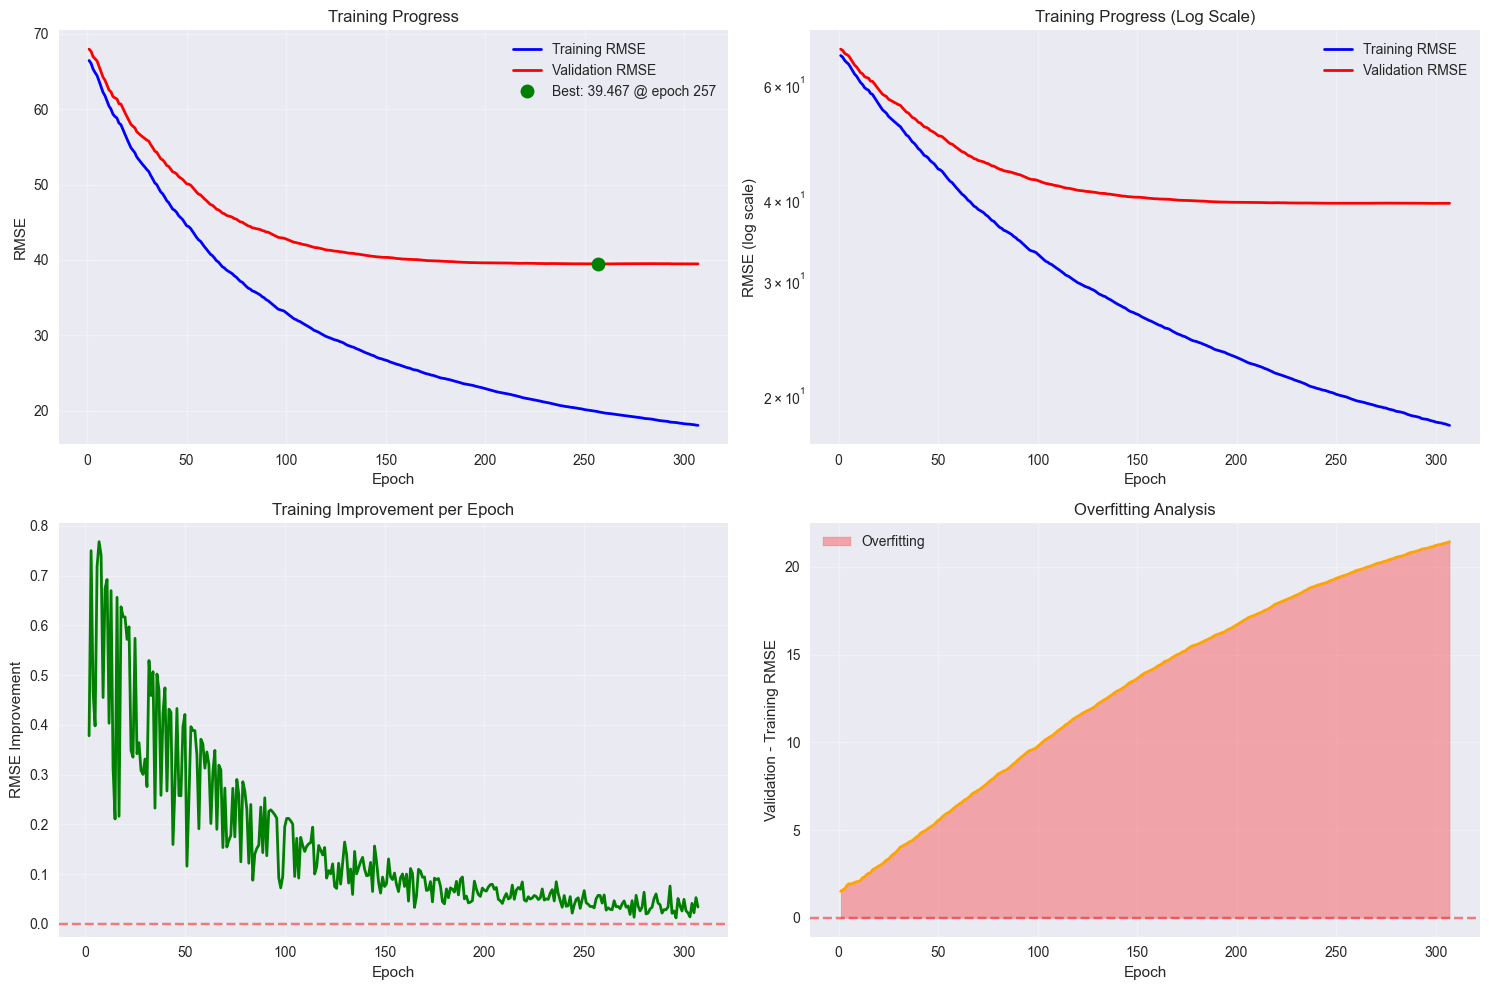


Training completed successfully!
Total time: 518.2s
Final test RMSE: 40.84 days
Advanced CV RMSE: 39.85 ± 2.15 days
Optuna optimization completed in 8.7m
Test RMSE: 40.84 days

RUNNING SCENARIOS FOR FEATURE SET: FULL_WITH_LEAKAGE
Features: 34

--- SCENARIO 1: Baseline_full_with_leakage ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_full_with_leakage_baseline_v1
Model directory: ../models\scdb_duration_full_with_leakage_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 21 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 102 features

Training final model with parameters:
  objective: reg:squarederror
  ra

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 13.2174
Optuna study saved: ../models\scdb_duration_full_with_leakage_optuna_v1\scdb_duration_full_with_leakage_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_full_with_leakage_optuna_v1\scdb_duration_full_with_leakage_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 10.0751
  Fold 2/5 - RMSE: 12.4929
  Fold 3/5 - RMSE: 16.6512
  Fold 4/5 - RMSE: 17.7215
  Fold 5/5 - RMSE: 15.9921
Advanced CV RMSE: 14.59 ± 2.86
Average best iteration: 97

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 2035
  learning_rate: 0.06263562315745935
  max_depth: 16
  subsample: 0.7
  colsample_bytree: 0.95
  gamma: 0.09282379039452407
  min_child_weight: 8
  reg_lambda: 0.573191787149841
  reg_alpha: 0.026

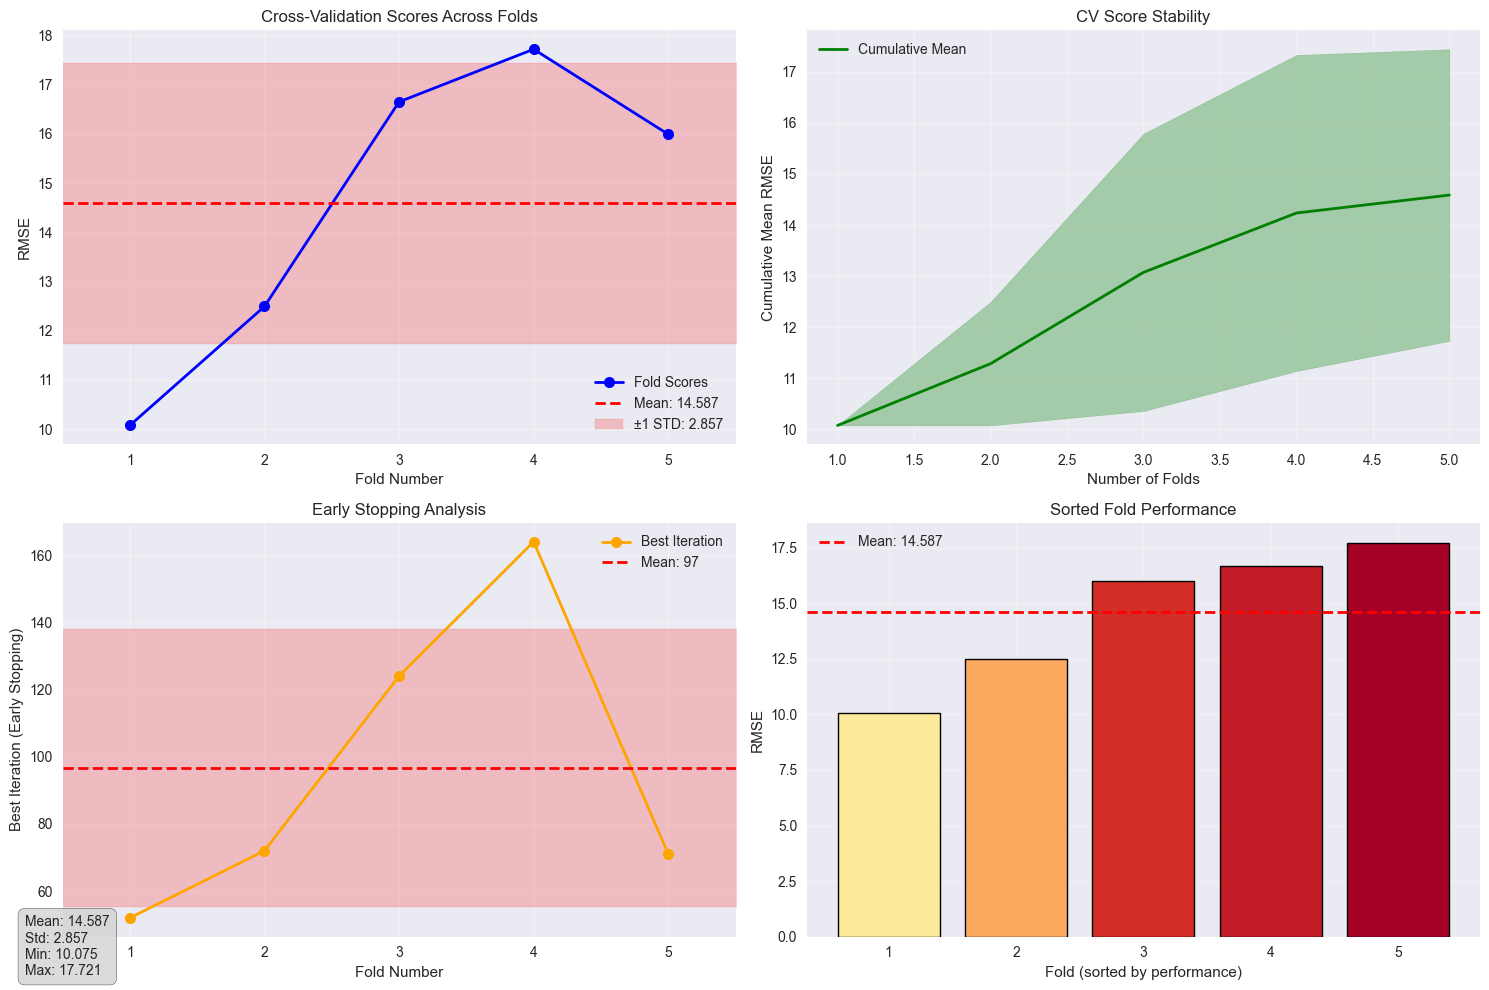

Creating training curve plots...


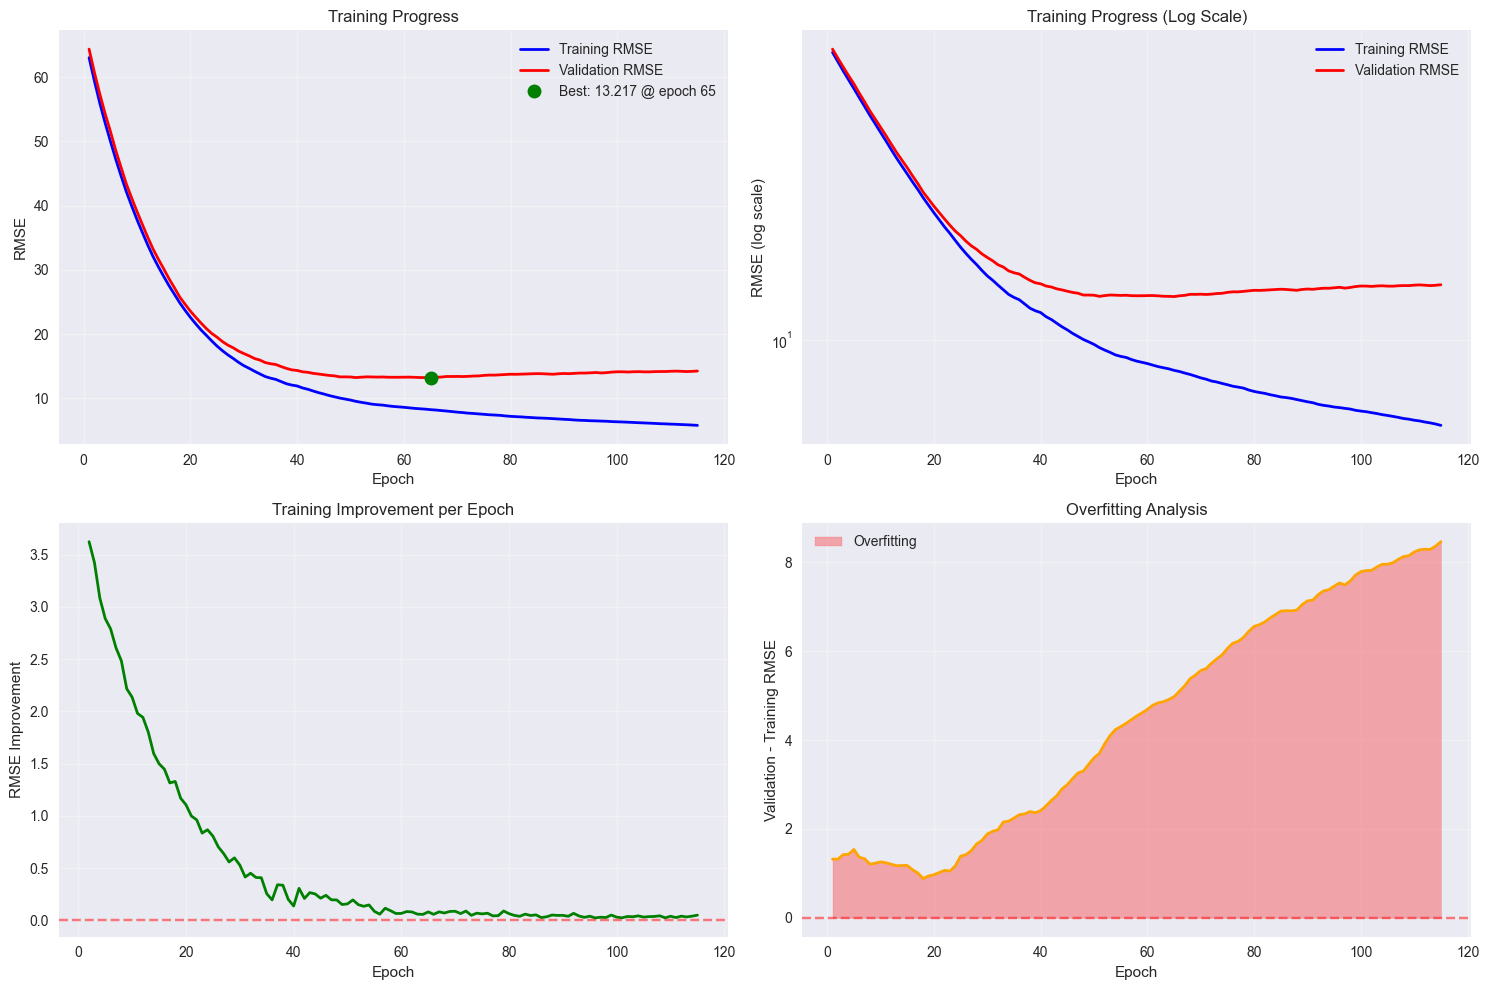


Training completed successfully!
Total time: 186.9s
Final test RMSE: 17.92 days
Advanced CV RMSE: 14.59 ± 2.86 days
Optuna optimization completed in 3.2m
Test RMSE: 17.92 days

LOG-TRANSFORMED TARGET EXPERIMENT

--- SCENARIO 4: LogTarget_Optuna_leakage_controlled ---
Purpose: Handle skewed target distribution with log transformation
Original target - Mean: 92.7, Std: 68.3
Log target - Mean: 4.33, Std: 0.67
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_logtarget_v1
Model directory: ../models\scdb_duration_leakage_controlled_logtarget_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 17 numerical and 13 categorical features
Fitting preprocessor...
Preprocessing complete: 98 features
Starting Op

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.4663
Optuna study saved: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 0.4837
  Fold 2/5 - RMSE: 0.4795
  Fold 3/5 - RMSE: 0.4832
  Fold 4/5 - RMSE: 0.4790
  Fold 5/5 - RMSE: 0.4409
Advanced CV RMSE: 0.47 ± 0.02
Average best iteration: 945

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 2069
  learning_rate: 0.007360420238857393
  max_depth: 13
  subsample: 0.95
  colsample_bytree: 0.65
  gamma: 0.011411660006569924
  min_child_weight: 3
  reg_lambda: 0.1118744534556867
  re

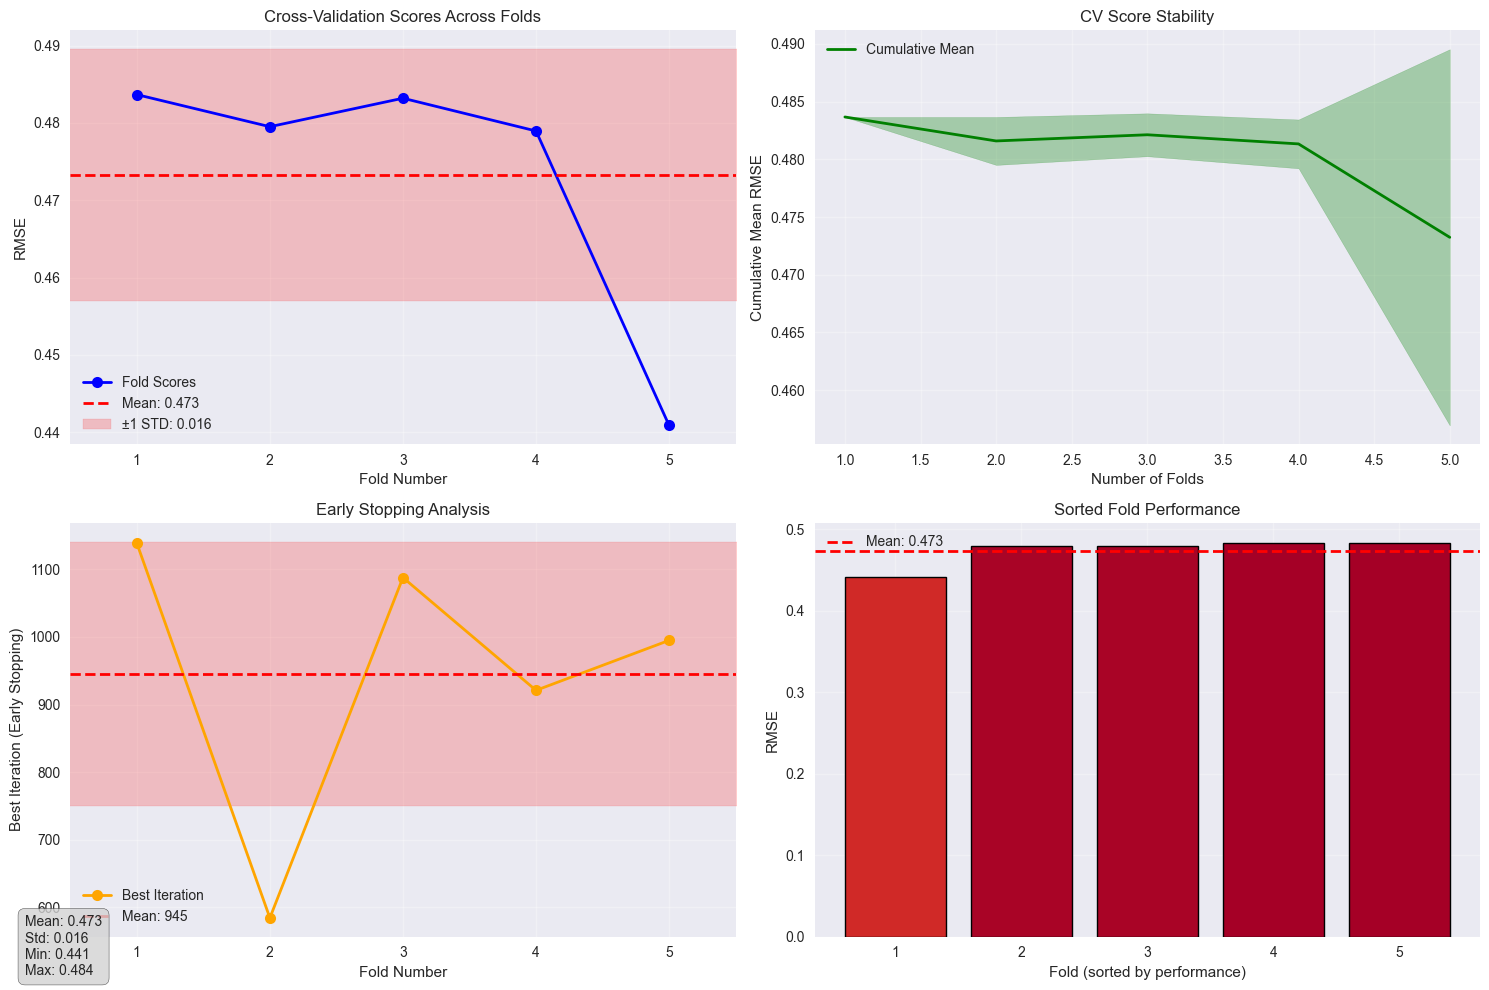

Creating training curve plots...


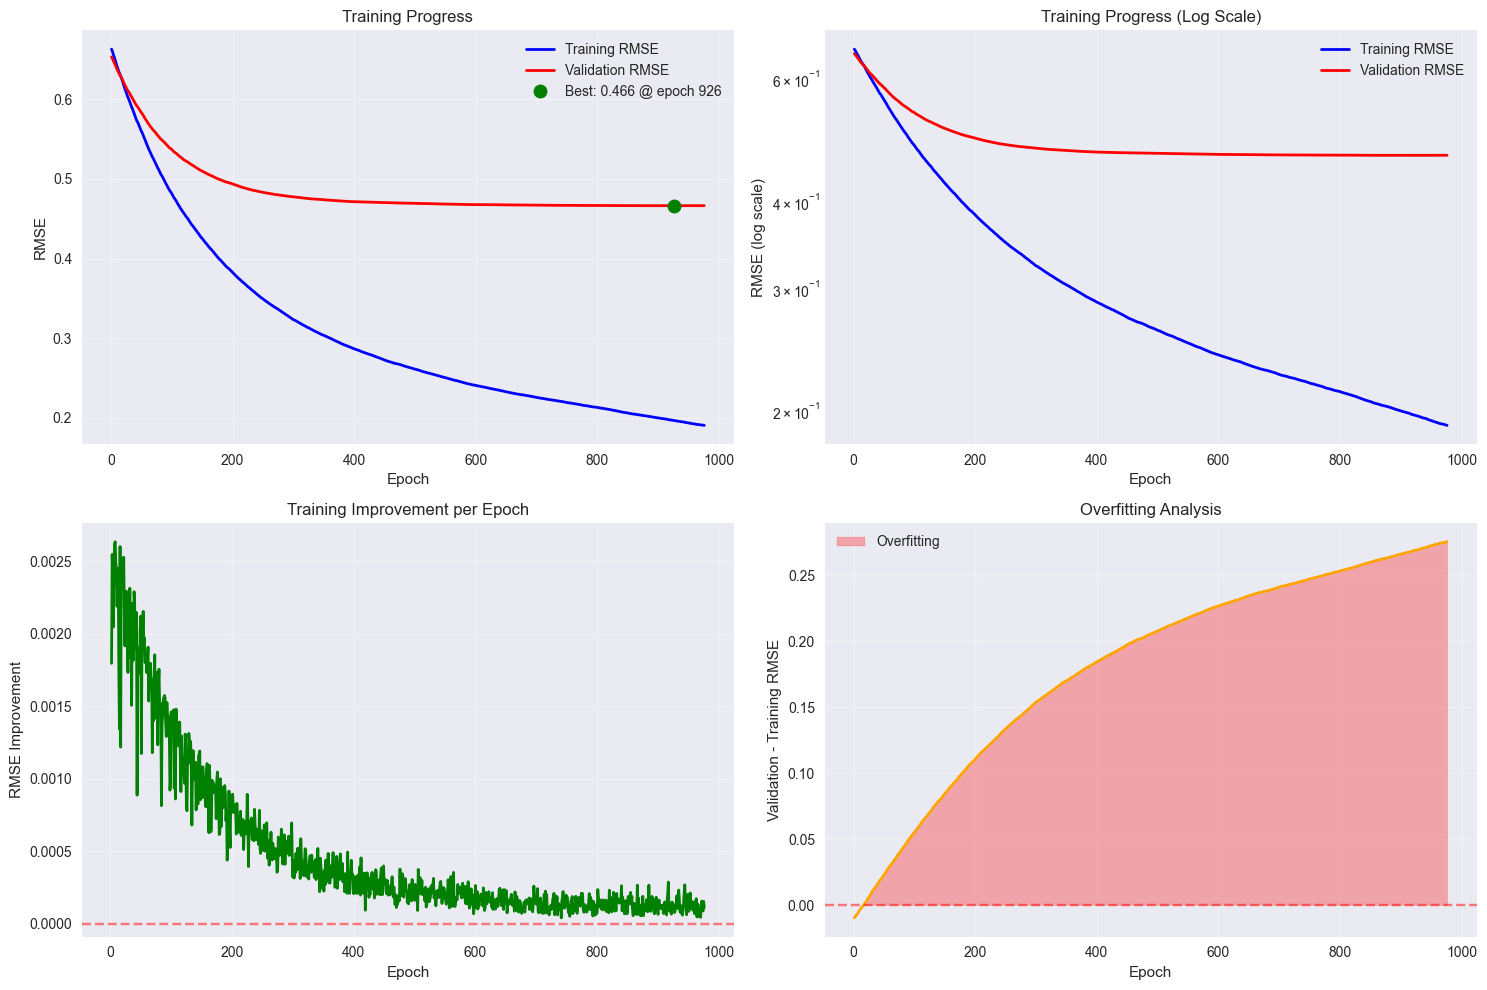


Training completed successfully!
Total time: 658.8s
Final test RMSE: 0.47 days
Advanced CV RMSE: 0.47 ± 0.02 days
Training completed in 662.5s
Test RMSE (original scale): 43.07 days

COMPILING AND COMPARING RESULTS

DETAILED MODEL COMPARISON:
                              Model  Train RMSE  Val RMSE  Test RMSE  Test MAE  Test R^2      CV RMSE  Training Time (s)  Features Used
           Optuna_full_with_leakage    8.244243 13.217443  17.915530  3.151238  0.939127 14.59 ± 2.86         190.659301            102
         Baseline_full_with_leakage    6.433560 15.572264  19.069563  4.500327  0.931032          N/A           2.351696            102
          Optuna_leakage_controlled   19.847983 39.467415  40.841484 27.027236  0.683648 39.85 ± 2.15         521.939247             98
        Baseline_leakage_controlled   31.280038 40.664929  41.226969 27.999406  0.677648          N/A           3.125223             98
                       Optuna_basic   28.338736 40.863612  42.663225 28.7573

In [ ]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os
import re
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# SECTION 2: FEATURE SET PREPARATION
# =============================================================================
print("="*80)
print("PREPARING FEATURE SETS FOR MODELING")
print("="*80)

# Prepare inputs for different feature sets
all_model_inputs = {}
if 'df_cleaned' in locals() and 'y' in locals() and \
   'numerical_features' in locals() and 'binary_features' in locals() and 'categorical_features' in locals() and \
   'basic_features_final' in locals() and 'leakage_controlled_features_final' in locals() and 'full_features_with_leakage_final' in locals():

    feature_sets_to_prepare = {
        "basic": basic_features_final,
        "leakage_controlled": leakage_controlled_features_final,
        "full_with_leakage": full_features_with_leakage_final
    }

    for set_name, selected_features_list in feature_sets_to_prepare.items():
        X_current = df_cleaned[selected_features_list]
        current_numerical = [f for f in numerical_features if f in X_current.columns]
        current_binary = [f for f in binary_features if f in X_current.columns]
        current_categorical = [f for f in categorical_features if f in X_current.columns]

        all_model_inputs[set_name] = {
            'X': X_current,
            'y': y,
            'numerical_for_trainer': current_numerical + current_binary,
            'categorical_for_trainer': current_categorical,
            'feature_list_name': set_name,
            'n_features': len(selected_features_list)
        }
        print(f"{set_name}: {len(selected_features_list)} features prepared")
else:
    print("Error: Prerequisite variables not defined. Please run preprocessing first.")
    all_model_inputs = {}

# =============================================================================
# SECTION 3: HYPERPARAMETER SEARCH SPACES
# =============================================================================
print("\n" + "="*80)
print("DEFINING HYPERPARAMETER SEARCH SPACES")
print("="*80)

# Define Optuna search spaces
optuna_search_space_xgb = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 2500},
    'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
    'max_depth': {'type': 'int', 'low': 4, 'high': 20},
    'subsample': {'type': 'float', 'low': 0.6, 'high': 0.95, 'step': 0.05},
    'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 0.95, 'step': 0.05},
    'gamma': {'type': 'float', 'low': 0.01, 'high': 1, 'log': True},
    'min_child_weight': {'type': 'int', 'low': 3, 'high': 15},
    'reg_lambda': {'type': 'float', 'low': 0.1, 'high': 5.0, 'log': True},
    'reg_alpha': {'type': 'float', 'low': 0.01, 'high': 5.0, 'log': True},
}

# Constrained search space for random search
random_search_space = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 1500},
    'learning_rate': {'type': 'float', 'low': 0.02, 'high': 0.08},
    'max_depth': {'type': 'int', 'low': 5, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.7, 'high': 0.9},
    'colsample_bytree': {'type': 'float', 'low': 0.7, 'high': 0.9},
}

print("Optuna search space defined")
print("Random search space defined (constrained)")

# Dictionary to store all results
all_scenario_results = {}

# =============================================================================
# SECTION 4: XGBOOST MODEL TRAINING (MULTIPLE SCENARIOS)
# =============================================================================
print("\n" + "="*80)
print("STARTING XGBOOST MODEL TRAINING")
print("="*80)

# Loop through feature sets
for set_name_key, inputs in all_model_inputs.items():
    print(f"\n" + "="*80)
    print(f"RUNNING SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
    print(f"Features: {inputs['n_features']}")
    print("="*80)

    current_X = inputs['X']
    current_y = inputs['y']
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    # -------------------------------------------------------------------------
    # SCENARIO 1: BASELINE MODEL
    # -------------------------------------------------------------------------
    scenario_model_name_1 = f'Baseline_{set_name_key}'
    print(f"\n--- SCENARIO 1: {scenario_model_name_1} ---")
    print("Purpose: Establish baseline with default XGBoost parameters")
    
    start_time = time.time()
    results_fs_baseline = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_baseline',
        early_stopping_rounds=50, 
        create_plots=True, 
        perform_cv=False
    )
    run_time = time.time() - start_time
    
    if results_fs_baseline:
        results_fs_baseline['training_time'] = run_time
        print(f"Training completed in {run_time:.1f}s")
        if results_fs_baseline.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_baseline['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_1] = results_fs_baseline

    # # -------------------------------------------------------------------------
    # # SCENARIO 2: RANDOM SEARCH
    # # -------------------------------------------------------------------------
    # scenario_model_name_2 = f'RandomSearch_{set_name_key}'
    # print(f"\n--- SCENARIO 2: {scenario_model_name_2} ---")
    # print("Purpose: Hyperparameter optimization with RandomizedSearchCV")
    
    # random_search_config = {
    #     'n_iter': 30,  # Reduced iterations for faster execution
    #     'cv': 3        # 3-fold CV
    # }
    
    # start_time = time.time()
    # results_fs_random = trainer.train_model(
    #     X=current_X, y=current_y,
    #     numerical_features=current_num_for_trainer, 
    #     categorical_features=current_cat_for_trainer,
    #     model_name=f'scdb_duration_{set_name_key}_random',
    #     optimization_method='random',
    #     optimization_params=random_search_config,
    #     early_stopping_rounds=50,
    #     create_plots=True,
    #     perform_cv=False
    # )
    # run_time = time.time() - start_time
    
    # if results_fs_random:
    #     results_fs_random['training_time'] = run_time
    #     print(f"Random search completed in {run_time:.1f}s")
    #     if results_fs_random.get('metrics', {}).get('test'):
    #         print(f"Test RMSE: {results_fs_random['metrics']['test']['rmse']:.2f} days")
    # all_scenario_results[scenario_model_name_2] = results_fs_random

    # -------------------------------------------------------------------------
    # SCENARIO 3: OPTUNA OPTIMIZATION
    # -------------------------------------------------------------------------
    scenario_model_name_3 = f'Optuna_{set_name_key}'
    print(f"\n--- SCENARIO 3: {scenario_model_name_3} ---")
    print("Purpose: Advanced hyperparameter optimization with Optuna")
    
    start_time = time.time()
    results_fs_optuna = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_optuna',
        optimization_method='optuna',
        optimization_params={
            'n_trials': 100, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=50, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    if results_fs_optuna:
        results_fs_optuna['training_time'] = run_time
        print(f"Optuna optimization completed in {run_time/60:.1f}m")
        if results_fs_optuna.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_3] = results_fs_optuna

# =============================================================================
# SECTION 5: LOG-TRANSFORMED TARGET 
# =============================================================================
print("\n" + "="*80)
print("LOG-TRANSFORMED TARGET EXPERIMENT")
print("="*80)

# Only run on leakage_controlled feature set -> example of usage for one set
if 'leakage_controlled' in all_model_inputs:
    scenario_model_name_4 = f'LogTarget_Optuna_leakage_controlled'
    print(f"\n--- SCENARIO 4: {scenario_model_name_4} ---")
    print("Purpose: Handle skewed target distribution with log transformation")
    
    current_X = all_model_inputs['leakage_controlled']['X']
    current_y = all_model_inputs['leakage_controlled']['y']
    y_log_current = np.log1p(current_y)
    
    print(f"Original target - Mean: {current_y.mean():.1f}, Std: {current_y.std():.1f}")
    print(f"Log target - Mean: {y_log_current.mean():.2f}, Std: {y_log_current.std():.2f}")
    
    start_time = time.time()
    results_fs_log = trainer.train_model(
        X=current_X, y=y_log_current,
        numerical_features=all_model_inputs['leakage_controlled']['numerical_for_trainer'], 
        categorical_features=all_model_inputs['leakage_controlled']['categorical_for_trainer'],
        model_name=f'scdb_duration_leakage_controlled_logtarget',
        optimization_method='optuna',
        optimization_params={
            'n_trials': 100, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=50, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    # Convert predictions back to original scale
    if results_fs_log:
        results_fs_log['training_time'] = run_time
        log_y_test_actual = results_fs_log.get('y_test')
        log_y_test_pred = results_fs_log.get('y_test_pred')
        if log_y_test_actual is not None and log_y_test_pred is not None:
            orig_y_test_actual = np.expm1(log_y_test_actual)
            orig_y_test_pred = np.expm1(log_y_test_pred)
            rmse_orig = np.sqrt(mean_squared_error(orig_y_test_actual, orig_y_test_pred))
            mae_orig = mean_absolute_error(orig_y_test_actual, orig_y_test_pred)
            r2_orig = r2_score(orig_y_test_actual, orig_y_test_pred)
            results_fs_log['metrics_original_scale'] = {
                'rmse': rmse_orig, 
                'mae': mae_orig, 
                'r2': r2_orig
            }
            print(f"Training completed in {run_time:.1f}s")
            print(f"Test RMSE (original scale): {rmse_orig:.2f} days")
    all_scenario_results[scenario_model_name_4] = results_fs_log

# # =============================================================================
# # SECTION 6: AUTOGLUON BENCHMARK -> for now commented out
# # =============================================================================
# print("\n" + "="*80)
# print("AUTOGLUON AUTOML BENCHMARK")
# print("="*80)

# scenario_model_name_5 = 'Autogluon_LeakageControlled'
# print(f"\n--- SCENARIO 5: {scenario_model_name_5} ---")
# print("Purpose: Benchmark against AutoML solution")

# if 'leakage_controlled' in all_model_inputs:
#     X_for_ag = all_model_inputs['leakage_controlled']['X'].copy()
#     y_for_ag = all_model_inputs['leakage_controlled']['y'].copy()
    
#     target_col_name = 'case_duration_days'
#     autogluon_data = X_for_ag.copy()
#     autogluon_data[target_col_name] = y_for_ag

#     # Use same random state for fair comparison
#     ag_train_df, ag_test_df = train_test_split(
#         autogluon_data, test_size=0.2, random_state=42
#     )
    
#     print(f"AutoGluon training data: {len(ag_train_df)} samples")
#     print(f"AutoGluon test data: {len(ag_test_df)} samples")
    
#     ag_save_path = '../models/autogluon_scdb_duration_leakage_controlled'
    
#     try:
#         autogluon_predictor = TabularPredictor(
#             label=target_col_name, 
#             path=ag_save_path,
#             problem_type='regression', 
#             eval_metric='rmse'
#         )
        
#         time_limit_ag = 240  # 4 minutes
#         start_time_ag = time.time()
#         autogluon_predictor.fit(
#             train_data=ag_train_df, 
#             presets='good_quality_faster_inference_only_refit',
#             time_limit=time_limit_ag
#         )
#         ag_train_time = time.time() - start_time_ag
#         print(f"AutoGluon training completed in {ag_train_time/60:.1f} minutes")

#         # Evaluate
#         ag_performance = autogluon_predictor.evaluate(ag_test_df)
#         ag_test_rmse = abs(ag_performance.get('rmse', np.nan))
#         ag_test_mae = abs(ag_performance.get('mae', np.nan))
#         ag_test_r2 = ag_performance.get('r2', np.nan)
        
#         print(f"AutoGluon Test RMSE: {ag_test_rmse:.2f} days")
        
#         # Get leaderboard
#         ag_leaderboard = autogluon_predictor.leaderboard(ag_test_df, silent=True)
#         best_model_info = ag_leaderboard.iloc[0]
        
#         all_scenario_results[scenario_model_name_5] = {
#             'metrics': {
#                 'train': {'rmse': np.nan, 'mae': np.nan},
#                 'validation': {'rmse': best_model_info['score_val'], 'mae': np.nan},
#                 'test': {'rmse': ag_test_rmse, 'mae': ag_test_mae, 'r2': ag_test_r2}
#             },
#             'model_name': f"AutoGluon_{best_model_info['model']}",
#             'training_time': ag_train_time,
#             'model_metadata': {
#                 'notes': 'AutoGluon on leakage_controlled features',
#                 'best_model': best_model_info['model'],
#                 'training_time': ag_train_time
#             }
#         }
#     except Exception as e:
#         print(f"AutoGluon failed: {e}")
#         all_scenario_results[scenario_model_name_5] = None

# =============================================================================
# SECTION 7: RESULTS COMPILATION AND COMPARISON
# =============================================================================
print("\n" + "="*80)
print("COMPILING AND COMPARING RESULTS")
print("="*80)

# Create comprehensive comparison dataframe
comparison_data = []
for name, results in all_scenario_results.items():
    if not results:
        continue
    
    model_entry = {'Model': name}
    metrics = results.get('metrics', {})
    
    # Training metrics
    train_metrics = metrics.get('train', {})
    val_metrics = metrics.get('validation', {})
    
    # Handle log-transformed metrics
    if 'metrics_original_scale' in results:
        test_metrics = results['metrics_original_scale']
    else:
        test_metrics = metrics.get('test', {})
    
    # Add all metrics
    model_entry['Train RMSE'] = train_metrics.get('rmse', np.nan)
    model_entry['Train MAE'] = train_metrics.get('mae', np.nan)
    model_entry['Val RMSE'] = val_metrics.get('rmse', np.nan)
    model_entry['Val MAE'] = val_metrics.get('mae', np.nan)
    model_entry['Test RMSE'] = test_metrics.get('rmse', np.nan)
    model_entry['Test MAE'] = test_metrics.get('mae', np.nan)
    model_entry['Test R^2'] = test_metrics.get('r2', np.nan)
    
    # Add CV results if available
    if 'cv_results' in results and results['cv_results']:
        cv_res = results['cv_results']
        model_entry['CV RMSE'] = f"{cv_res['cv_mean']:.2f} ± {cv_res['cv_std']:.2f}"
        model_entry['CV Folds'] = cv_res.get('cv_folds', 'N/A')
    else:
        model_entry['CV RMSE'] = 'N/A'
        model_entry['CV Folds'] = 'N/A'
    
    # Add training time
    model_entry['Training Time (s)'] = results.get('training_time', np.nan)
    
    # Add feature count
    if 'feature_names' in results:
        model_entry['Features Used'] = len(results['feature_names'])
    else:
        # Extract from model name
        if 'basic' in name.lower():
            model_entry['Features Used'] = all_model_inputs['basic']['n_features']
        elif 'leakage_controlled' in name.lower():
            model_entry['Features Used'] = all_model_inputs['leakage_controlled']['n_features']
        elif 'full' in name.lower():
            model_entry['Features Used'] = all_model_inputs['full_with_leakage']['n_features']
    
    # Add model path
    model_entry['Model Path'] = results.get('model_path', 'N/A')
    
    comparison_data.append(model_entry)

# Create and display comparison dataframe
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test RMSE', ascending=True)

print("\nDETAILED MODEL COMPARISON:")
print("="*100)
display_cols = ['Model', 'Train RMSE', 'Val RMSE', 'Test RMSE', 'Test MAE', 'Test R^2', 'CV RMSE', 'Training Time (s)', 'Features Used']
print(comparison_df[display_cols].to_string(index=False))

# =============================================================================
# SECTION 8: SAVE RESULTS AND IDENTIFY BEST MODELS
# =============================================================================
print("\n" + "="*80)
print("SAVING RESULTS AND IDENTIFYING BEST MODELS")
print("="*80)

# Save detailed results
output_csv_path = '../data/model_results/model_comparison_detailed.csv'
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
comparison_df.to_csv(output_csv_path, index=False)
print(f"Detailed results saved to '{output_csv_path}'")

# Identify best models
if len(comparison_df) > 0:
    # Best overall
    best_overall = comparison_df.iloc[0]
    print(f"\n BEST OVERALL MODEL: {best_overall['Model']}")
    print(f"   Test RMSE: {best_overall['Test RMSE']:.2f} days")
    print(f"   Test MAE: {best_overall['Test MAE']:.2f} days")
    print(f"   Test R^2: {best_overall['Test R^2']:.4f}")
    print(f"   Training Time: {best_overall['Training Time (s)']:.1f}s")
    
    # Best without leakage
    no_leakage_df = comparison_df[~comparison_df['Model'].str.contains('full_with_leakage')]
    if len(no_leakage_df) > 0:
        best_no_leakage = no_leakage_df.iloc[0]
        print(f"\n BEST MODEL WITHOUT LEAKAGE: {best_no_leakage['Model']}")
        print(f"   Test RMSE: {best_no_leakage['Test RMSE']:.2f} days")
        print(f"   Model Path: {best_no_leakage['Model Path']}")
    
    # Store best model paths for later use
    best_models = {
        'best_overall': {
            'name': best_overall['Model'],
            'path': best_overall['Model Path'],
            'rmse': best_overall['Test RMSE']
        },
        'best_no_leakage': {
            'name': best_no_leakage['Model'],
            'path': best_no_leakage['Model Path'],
            'rmse': best_no_leakage['Test RMSE']
        } if len(no_leakage_df) > 0 else None
    }
    
    # Save best models info
    import json
    with open('../data/model_results/best_models_info.json', 'w') as f:
        json.dump(best_models, f, indent=2)
    print("\n Best models information saved for further analysis")

 I WANT DESCRIPTION OF OUTPUT some brief

## 6. Handling the model outputs

Results Comparison: Create a summary table (e.g., a pandas DataFrame) from the all_results dictionary to compare the Test RMSE, MAE, and R^2 across all feature sets and scenarios. This will clearly show which model performed best.

In [10]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from typing import Dict, List, Optional, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# --- Import your custom utility and training modules ---
import sys
try:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) 
    from src.model_utils import list_trained_models, load_model_artifacts, get_data_splits_from_metadata
    from src.train_model import XGBoostModelTrainer
    print("Successfully imported custom modules.")
except ImportError as e:
    print(f"ImportError: {e}. Make sure 'src' directory is accessible.")

# --- Import XAI and Plotting Libraries ---
try:
    import shap
    import lime
    import lime.lime_tabular
    import dalex as dx
    import optuna
    import optuna.visualization as vis
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    print("Successfully imported XAI libraries.")
except ImportError as e:
    print(f"Missing XAI libraries: {e}")

# --- Notebook Setup - visuals corrected ---
sns.set_theme(style="whitegrid", palette="husl")
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

Successfully imported custom modules.
Successfully imported XAI libraries.


In [11]:
# =============================================================================
# SECTION 2: FEATURE NAME MAPPING FOR READABILITY
# =============================================================================
# Create readable feature names mapping for *business presentation*  
FEATURE_DISPLAY_NAMES = {
    # Temporal Features
    'month_of_argument': 'Argument Month',
    'month_of_decision': 'Decision Month',
    'year_of_decision': 'Decision Year',
    'days_term_start_to_argument': 'Days: Term Start to Argument',
    'days_term_start_to_decision': 'Days: Term Start to Decision',
    'is_argument_late_in_term': 'Late Term Argument',
    'is_decision_late_in_term': 'Late Term Decision',
    
    # Court Structure
    'chief_justice_sname': 'Chief Justice',
    'natural_court_period': 'Natural Court Period',
    'court_term_year': 'Court Term Year',
    
    # Case Categories
    'case_origin_type': 'Case Origin Type',
    'case_source_type': 'Case Source Type',
    'case_docket_type': 'Docket Type',
    'jurisdiction_type': 'Jurisdiction Type',
    'cert_reason_category': 'Cert Reason Category',
    
    # Legal Issues
    'specific_legal_issue_grouped': 'Legal Issue (Grouped)',
    'broad_issue_area': 'Broad Issue Area',
    'law_type_category': 'Law Type Category',
    
    # Parties
    'petitioner_type': 'Petitioner Type',
    'respondent_type': 'Respondent Type',
    'is_govt_vs_business_case': 'Government vs Business',
    'is_individual_vs_govt_case': 'Individual vs Government',
    'is_state_vs_state_case': 'State vs State',
    
    # Lower Court
    'lower_court_disagreement': 'Lower Court Disagreement',
    'lower_court_ideological_direction': 'Lower Court Ideology',
    'lower_court_disposition_type': 'Lower Court Disposition',
    'lower_court_disagree_ideology': 'Lower Court Disagree Ideology',
    
    # Complexity
    'consolidated_dockets_count': 'Consolidated Dockets',
    'complexity_score_consolidated_disagree': 'Complexity Score',
    'three_judge_district_court': 'Three Judge District Court',
    
    # Specialized
    'is_admin_economic_case': 'Admin Economic Case',
    'is_federal_circuit_conflict': 'Federal Circuit Conflict',
    
    # Missing Indicators
    'lower_court_disagree_was_missing': 'Lower Court Disagree Missing',
    'three_judge_info_was_missing': 'Three Judge Info Missing'
}

def get_readable_feature_name(feature_name: str) -> str:
    """Convert feature name to readable format"""
    # First check if it's in our mapping
    if feature_name in FEATURE_DISPLAY_NAMES:
        return FEATURE_DISPLAY_NAMES[feature_name]
    
    # Handle encoded categorical features (e.g., "chief_justice_sname_Warren")
    for orig_name, display_name in FEATURE_DISPLAY_NAMES.items():
        if feature_name.startswith(orig_name + '_'):
            suffix = feature_name[len(orig_name)+1:]
            return f"{display_name}: {suffix}"
    
    # Fallback: capitalize and replace underscores
    return feature_name.replace('_', ' ').title()

In [12]:
# =============================================================================
# SECTION 3: XAI ANALYSIS FUNCTIONS -> change for python file
# =============================================================================

def create_pdp_plots(pipeline, X, feature_names, top_n=6, figsize=(15, 10)):
    """Create Partial Dependence Plots for top features"""
    print("\nGenerating Partial Dependence Plots...")
    
    # Get feature importance
    xgb_model = pipeline.named_steps['regressor']
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features
    top_features = feature_importance.head(top_n)['feature'].tolist()
    top_indices = [list(feature_names).index(f) for f in top_features]
    
    # Create PDP display
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (feature_idx, feature_name) in enumerate(zip(top_indices, top_features)):
        if idx >= len(axes):
            break
            
        # Calculate partial dependence
        pd_result = partial_dependence(
            pipeline, X, [feature_idx],
            kind='average',
            grid_resolution=50
        )
        
        # Plot
        ax = axes[idx]
        ax.plot(pd_result['values'][0], pd_result['average'][0], 'b-', linewidth=2)
        ax.fill_between(
            pd_result['values'][0],
            pd_result['average'][0] - pd_result['std'][0],
            pd_result['average'][0] + pd_result['std'][0],
            alpha=0.2, color='blue'
        )
        ax.set_xlabel(get_readable_feature_name(feature_name))
        ax.set_ylabel('Partial Dependence')
        ax.set_title(f'PDP: {get_readable_feature_name(feature_name)}')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(top_indices), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

def create_ice_plots(pipeline, X, X_sample, feature_names, top_n=4, n_samples=100):
    """Create Individual Conditional Expectation plots"""
    print("\nGenerating ICE Plots...")
    
    # Get feature importance
    xgb_model = pipeline.named_steps['regressor']
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features
    top_features = feature_importance.head(top_n)['feature'].tolist()
    
    # Sample data
    if len(X_sample) > n_samples:
        sample_idx = np.random.choice(len(X_sample), n_samples, replace=False)
        X_ice = X_sample.iloc[sample_idx]
    else:
        X_ice = X_sample
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feature_name in enumerate(top_features):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        feature_idx = list(feature_names).index(feature_name)
        
        # Calculate ICE
        pd_result = partial_dependence(
            pipeline, X_ice, [feature_idx],
            kind='individual',
            grid_resolution=30
        )
        
        # Plot individual lines
        for i in range(pd_result['individual'][0].shape[0]):
            ax.plot(pd_result['values'][0], pd_result['individual'][0][i, :], 
                   'gray', alpha=0.3, linewidth=0.5)
        
        # Plot average
        ax.plot(pd_result['values'][0], pd_result['average'][0], 
               'red', linewidth=3, label='Average')
        
        ax.set_xlabel(get_readable_feature_name(feature_name))
        ax.set_ylabel('Prediction')
        ax.set_title(f'ICE Plot: {get_readable_feature_name(feature_name)}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_shap_waterfall(shap_values, X_processed, instance_idx=0):
    """Create SHAP waterfall plot for a single prediction"""
    print("\nGenerating SHAP Waterfall Plot...")
    
    # Create waterfall plot
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[instance_idx],
            base_values=float(shap_values[instance_idx].base_values) if hasattr(shap_values[instance_idx], 'base_values') else 0,
            data=X_processed.iloc[instance_idx].values,
            feature_names=[get_readable_feature_name(f) for f in X_processed.columns]
        ),
        max_display=15
    )
    
def create_error_analysis_plots(y_true, y_pred, X_test, feature_names, figsize=(15, 10)):
    """Create comprehensive error analysis plots"""
    print("\nGenerating Error Analysis Plots...")
    
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    
    fig = plt.figure(figsize=figsize)
    
    # 1. Error Distribution
    plt.subplot(2, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Prediction Error (days)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    
    # 2. Q-Q Plot
    plt.subplot(2, 3, 2)
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Errors')
    
    # 3. Error vs Predicted
    plt.subplot(2, 3, 3)
    plt.scatter(y_pred, errors, alpha=0.5, s=10)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Duration (days)')
    plt.ylabel('Error (days)')
    plt.title('Residuals vs Predicted Values')
    
    # 4. Absolute Error vs Actual
    plt.subplot(2, 3, 4)
    plt.scatter(y_true, abs_errors, alpha=0.5, s=10)
    z = np.polyfit(y_true, abs_errors, 1)
    p = np.poly1d(z)
    plt.plot(sorted(y_true), p(sorted(y_true)), "r--", alpha=0.8)
    plt.xlabel('Actual Duration (days)')
    plt.ylabel('Absolute Error (days)')
    plt.title('Absolute Error vs Actual Duration')
    
    # 5. Error by Percentile
    plt.subplot(2, 3, 5)
    percentiles = np.percentile(y_true, np.arange(0, 101, 10))
    error_by_percentile = []
    for i in range(len(percentiles)-1):
        mask = (y_true >= percentiles[i]) & (y_true < percentiles[i+1])
        error_by_percentile.append(np.mean(abs_errors[mask]))
    
    plt.bar(range(len(error_by_percentile)), error_by_percentile, 
            color='green', alpha=0.7, edgecolor='black')
    plt.xlabel('Duration Percentile')
    plt.ylabel('Mean Absolute Error (days)')
    plt.title('Error by Duration Percentile')
    plt.xticks(range(len(error_by_percentile)), 
               [f'{i*10}-{(i+1)*10}' for i in range(len(error_by_percentile))], 
               rotation=45)
    
    # 6. Feature vs Error (for top feature)
    plt.subplot(2, 3, 6)
    # Get most important feature
    top_feature_idx = 0  # You might want to determine this dynamically
    top_feature = X_test.iloc[:, top_feature_idx]
    
    # Bin the feature
    if len(np.unique(top_feature)) > 20:
        bins = pd.qcut(top_feature, q=10, duplicates='drop')
        error_by_bin = abs_errors.groupby(bins).mean()
        plt.bar(range(len(error_by_bin)), error_by_bin.values, 
                color='orange', alpha=0.7, edgecolor='black')
        plt.xlabel(f'{feature_names[top_feature_idx]} (Binned)')
        plt.xticks(range(len(error_by_bin)), 
                   [f'{int(b.left)}-{int(b.right)}' for b in error_by_bin.index], 
                   rotation=45)
    else:
        error_by_value = abs_errors.groupby(top_feature).mean()
        plt.bar(range(len(error_by_value)), error_by_value.values, 
                color='orange', alpha=0.7, edgecolor='black')
        plt.xlabel(feature_names[top_feature_idx])
        plt.xticks(range(len(error_by_value)), error_by_value.index, rotation=45)
    
    plt.ylabel('Mean Absolute Error (days)')
    plt.title(f'Error by {get_readable_feature_name(feature_names[top_feature_idx])}')
    
    plt.tight_layout()
    return fig

def create_dalex_advanced_plots(explainer, X_test, y_test, feature_names):
    """Create advanced DALEX plots including aggregated profiles"""
    print("\nGenerating Advanced DALEX Visualizations...")
    
    # Model Performance
    mp = explainer.model_performance()
    
    # Aggregated Profiles (similar to PDP but with DALEX)
    print("  Creating aggregated profiles...")
    ap = explainer.model_profile(type='partial', N=1000)
    
    # Create custom plot for aggregated profiles
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Get top 6 features
    top_features = explainer.model_parts().result.head(6)['variable'].tolist()
    
    for idx, feature in enumerate(top_features):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        feature_data = ap.result[ap.result['_vname_'] == feature]
        
        ax.plot(feature_data['_x_'], feature_data['_yhat_'], 'b-', linewidth=2)
        ax.set_xlabel(get_readable_feature_name(feature))
        ax.set_ylabel('Average Prediction')
        ax.set_title(f'Aggregated Profile: {get_readable_feature_name(feature)}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, mp, ap

def enhance_lime_visualization(lime_exp, feature_names, save_path=None):
    """Create enhanced LIME visualization with better styling"""
    print("\nEnhancing LIME visualization...")
    
    # Get explanation data
    exp_list = lime_exp.as_list()
    
    # Create custom visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    # Feature importance bar chart
    features = []
    impacts = []
    colors = []
    
    for feature, impact in exp_list[:15]:  # Top 15 features
        # Clean feature name
        clean_name = feature.split(' <= ')[0].split(' > ')[0]
        clean_name = get_readable_feature_name(clean_name)
        features.append(clean_name)
        impacts.append(impact)
        colors.append('green' if impact > 0 else 'red')
    
    y_pos = np.arange(len(features))
    ax1.barh(y_pos, impacts, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(features)
    ax1.set_xlabel('Impact on Prediction')
    ax1.set_title('Feature Contributions to Prediction')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Prediction details
    prediction = lime_exp.predicted_value
    ax2.text(0.1, 0.9, f'Predicted Value: {prediction:.2f} days', 
             transform=ax2.transAxes, fontsize=14, weight='bold')
    
    # Add feature values
    y_offset = 0.8
    for i, (feature, impact) in enumerate(exp_list[:10]):
        ax2.text(0.1, y_offset - i*0.08, f'{feature}: {impact:+.3f}', 
                 transform=ax2.transAxes, fontsize=11)
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Feature Details')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

In [13]:
# =============================================================================
# SECTION 4: LOAD DATA AND MODELS
# =============================================================================
print("\n--- Loading original dataset ---")
try:
    if 'df_cleaned' in locals() and 'y' in locals():
        print("Using pre-loaded df_cleaned and y.")
        DATA_LOADED = True
    else:
        raise NameError("Original data not found.")
except NameError:
    print("ERROR: `df_cleaned` and `y` are not defined. Please load your original dataset first.")
    DATA_LOADED = False

# --- Scan for available models ---
if DATA_LOADED:
    print("\n--- Scanning for available models ---")
    available_models = list_trained_models(models_base_dir="../models")
    if not available_models:
        print("No trained models found.")
    else:
        sorted_by_rmse = sorted(available_models, key=lambda x: x.get('test_rmse') if x.get('test_rmse') is not None else float('inf'))
        print(f"Found {len(sorted_by_rmse)} models (sorted by best Test RMSE):")
        for i, model_info in enumerate(sorted_by_rmse):
            rmse_str = f"{model_info.get('test_rmse'):.2f}" if model_info.get('test_rmse') is not None else "N/A"
            print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")


--- Loading original dataset ---
Using pre-loaded df_cleaned and y.

--- Scanning for available models ---
Found 7 models (sorted by best Test RMSE):
  [0] scdb_duration_leakage_controlled_logtarget_v1 (RMSE: 0.47)
  [1] scdb_duration_full_with_leakage_optuna_v1 (RMSE: 17.92)
  [2] scdb_duration_full_with_leakage_baseline_v1 (RMSE: 19.07)
  [3] scdb_duration_leakage_controlled_optuna_v1 (RMSE: 40.84)
  [4] scdb_duration_leakage_controlled_baseline_v1 (RMSE: 41.23)
  [5] scdb_duration_basic_optuna_v1 (RMSE: 42.66)
  [6] scdb_duration_basic_baseline_v1 (RMSE: 42.92)


We will load the model from the saved folder and use it for further analysis, such as XAI and predictions.

We will go with scdb_duration_full_with_leakage_optuna_v1 (RMSE: 17.92) and scdb_duration_leakage_controlled_optuna_v1 (RMSE: 40.84) for the sake of comparison.


PROCESSING MODEL [0]: scdb_duration_leakage_controlled_logtarget_v1

Loading artifacts for 'scdb_duration_leakage_controlled_logtarget_v1'...
Successfully loaded model pipeline from: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1.joblib
Successfully loaded Optuna study from: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna_study.joblib

Recreating data splits...
Recreating splits with params: {'test_size': 0.2, 'eval_size': 0.15, 'random_state_split': 420}, Stratify: True

1. Generating SHAP visualizations...


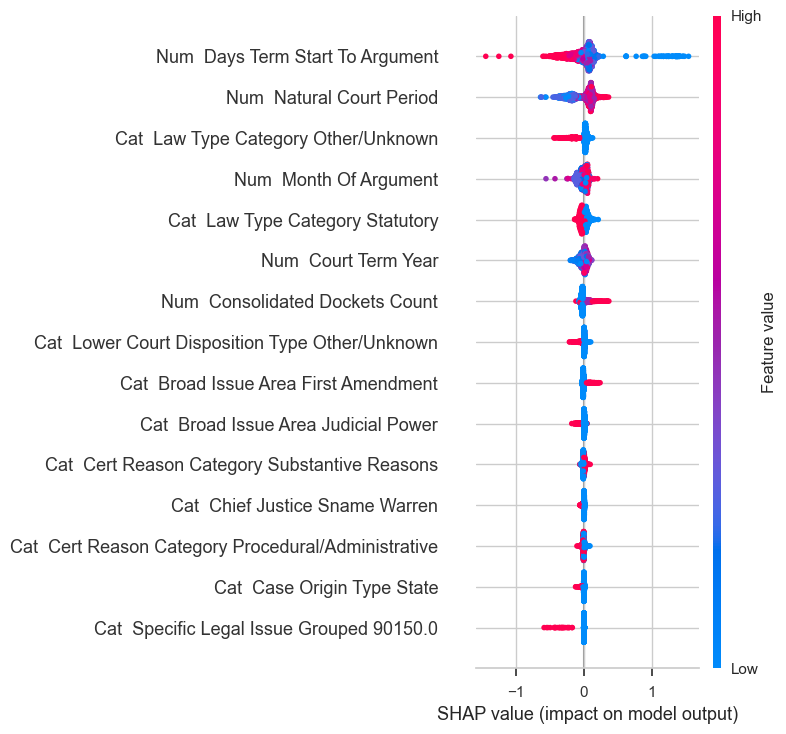

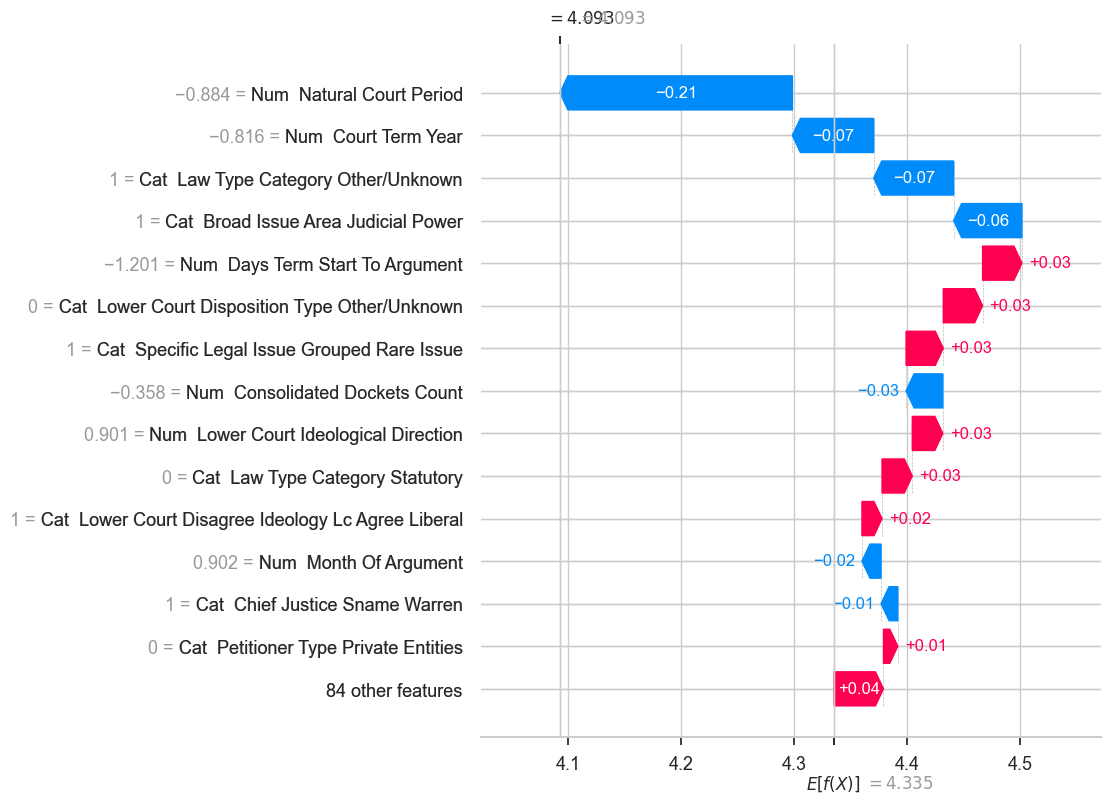

<Figure size 800x550 with 0 Axes>

  SHAP plots saved successfully

2. Generating Partial Dependence Plots...

Generating Partial Dependence Plots...
  PDP plots failed: all features must be in [0, 34] or [-35, 0]

3. Generating ICE Plots...

Generating ICE Plots...
  ICE plots failed: all features must be in [0, 34] or [-35, 0]

4. Generating Error Analysis...

Generating Error Analysis Plots...


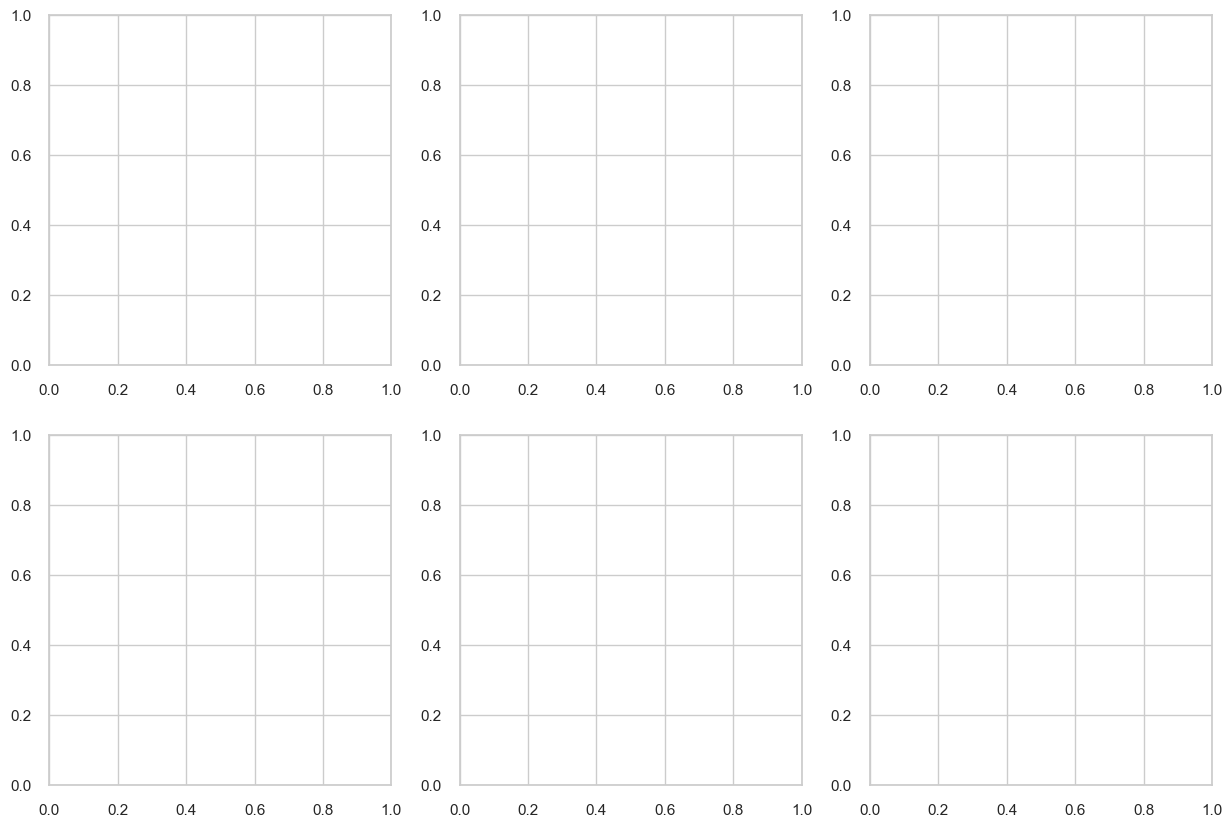

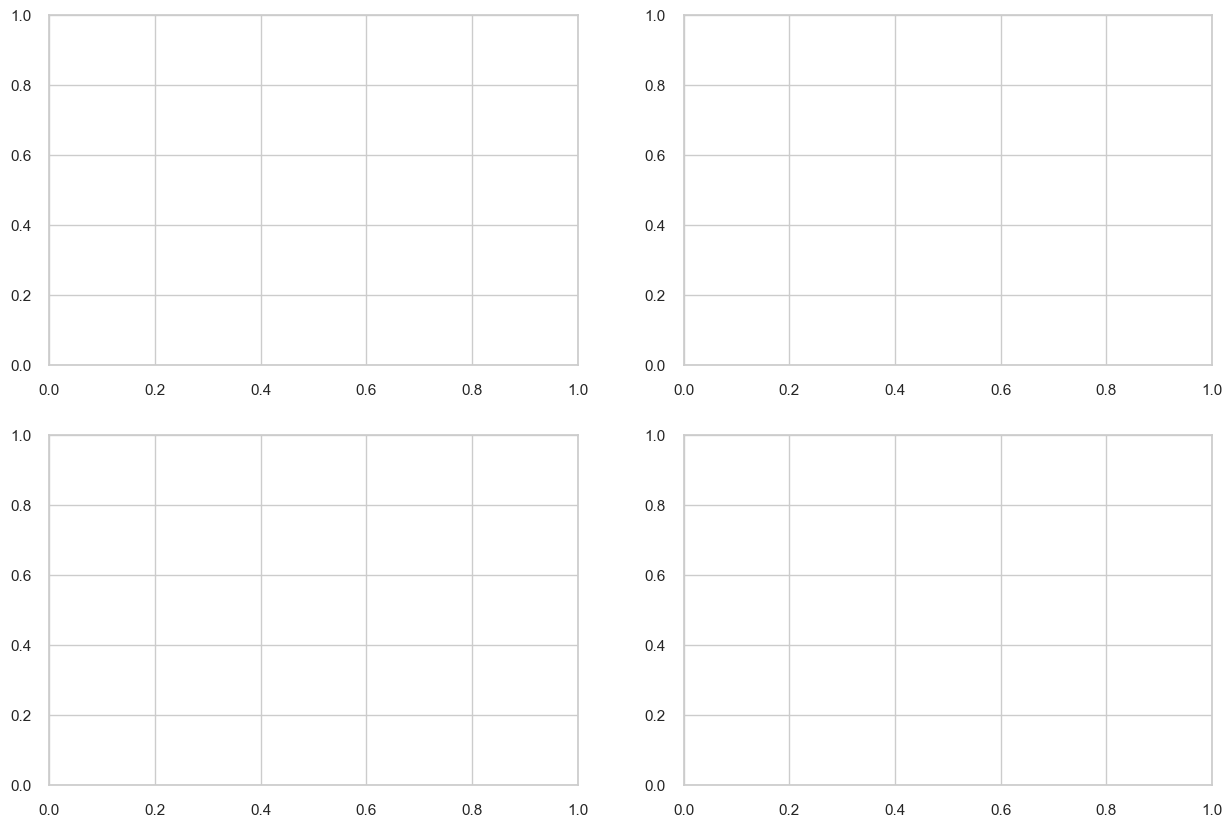

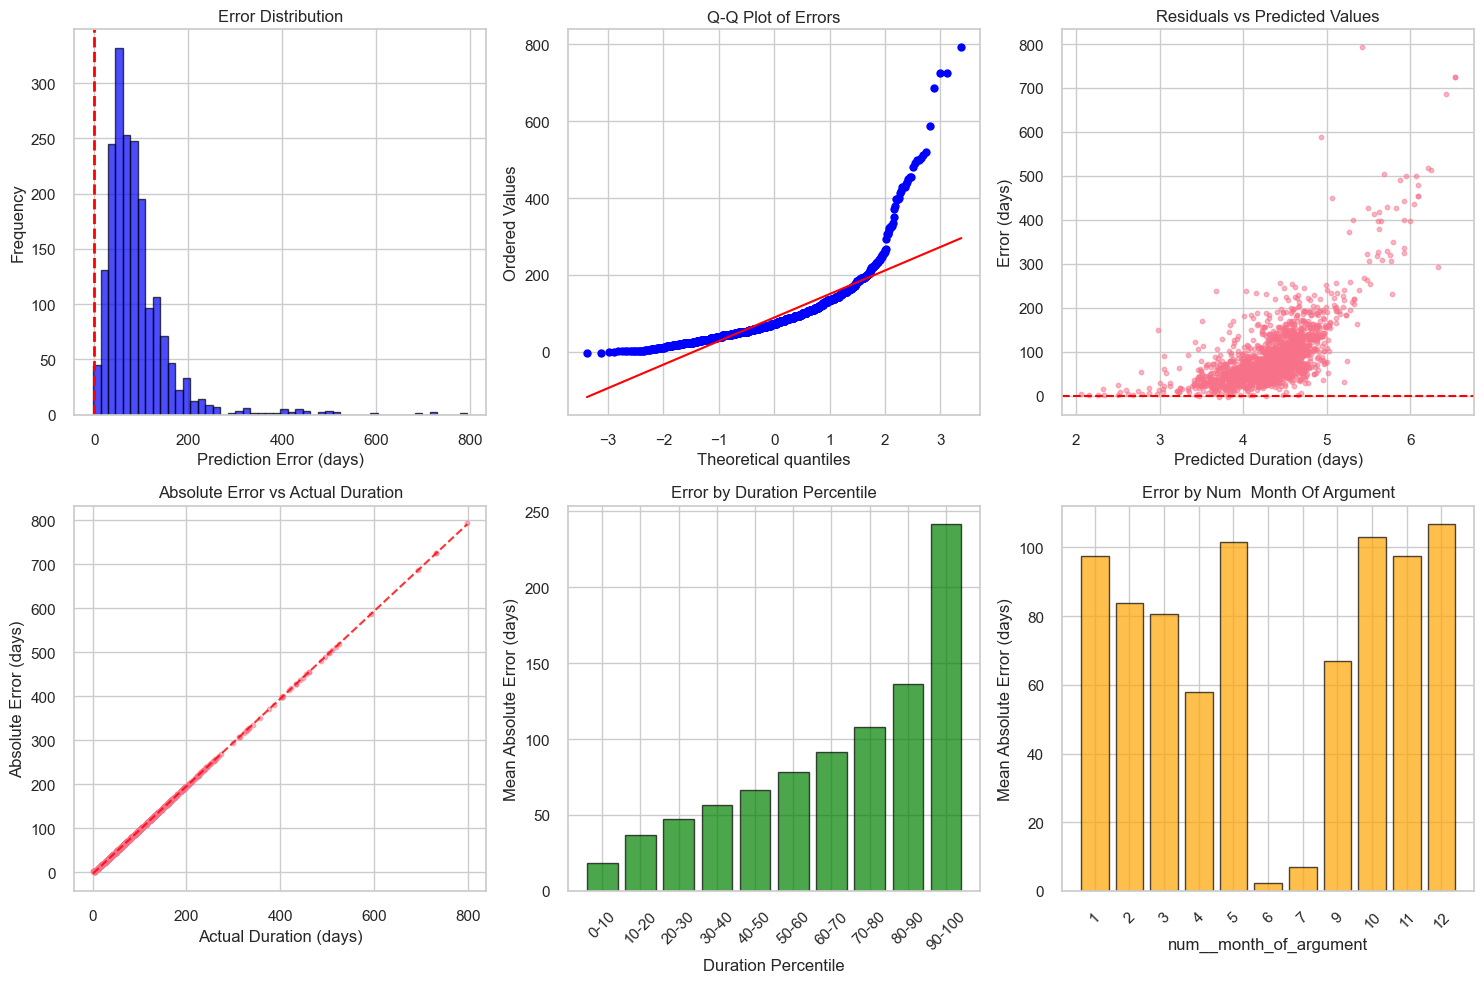

  Error analysis plots saved successfully

5. Generating Enhanced LIME visualization...

Enhancing LIME visualization...


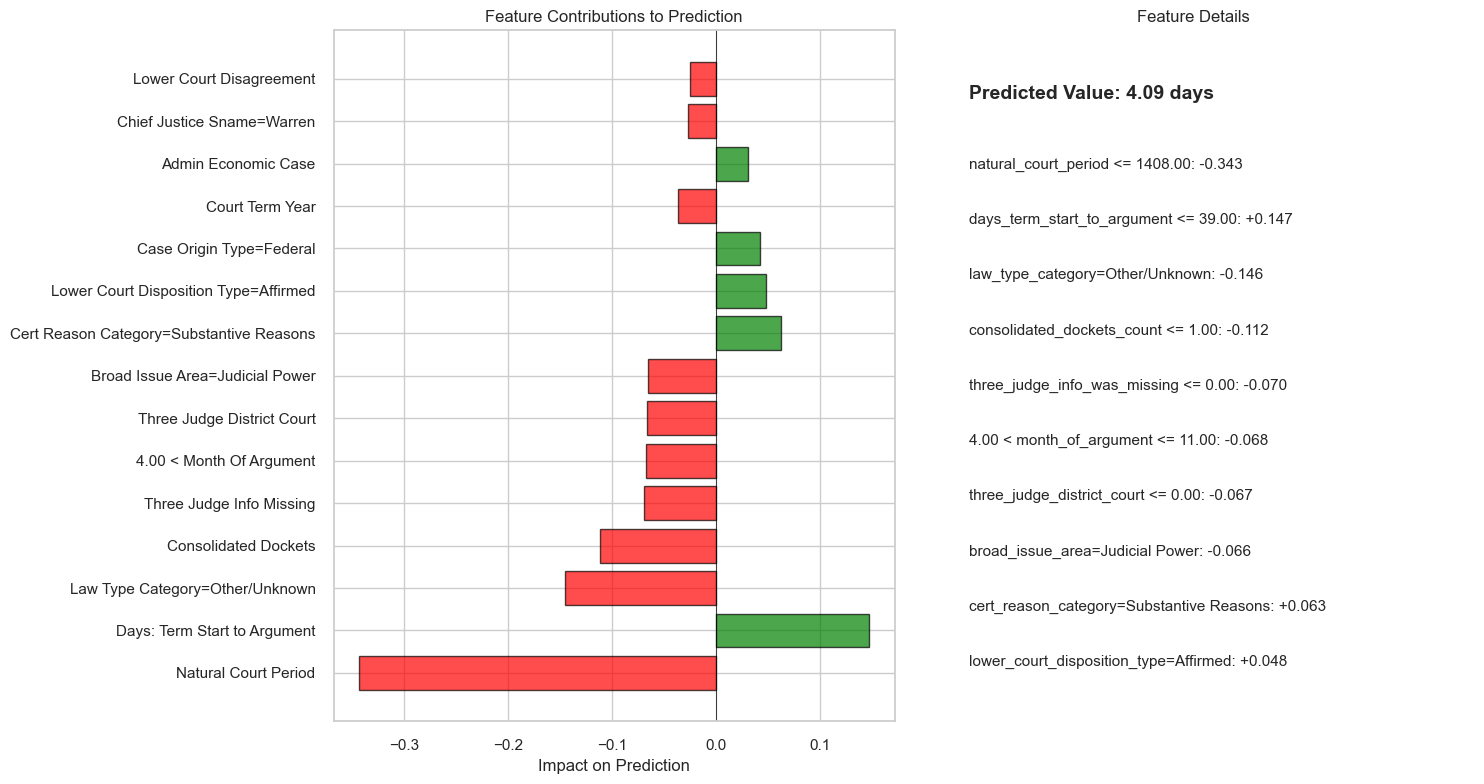


Enhancing LIME visualization...


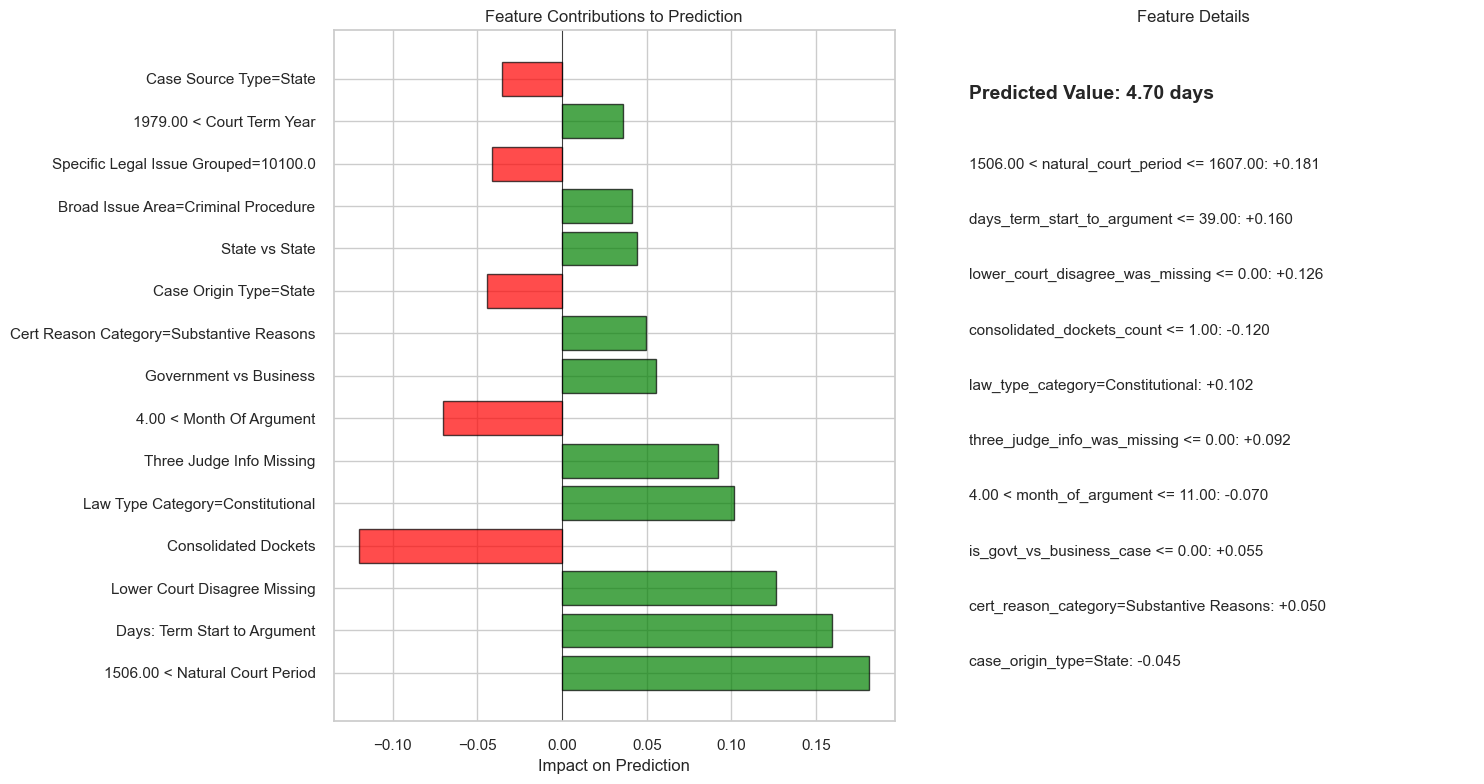


Enhancing LIME visualization...


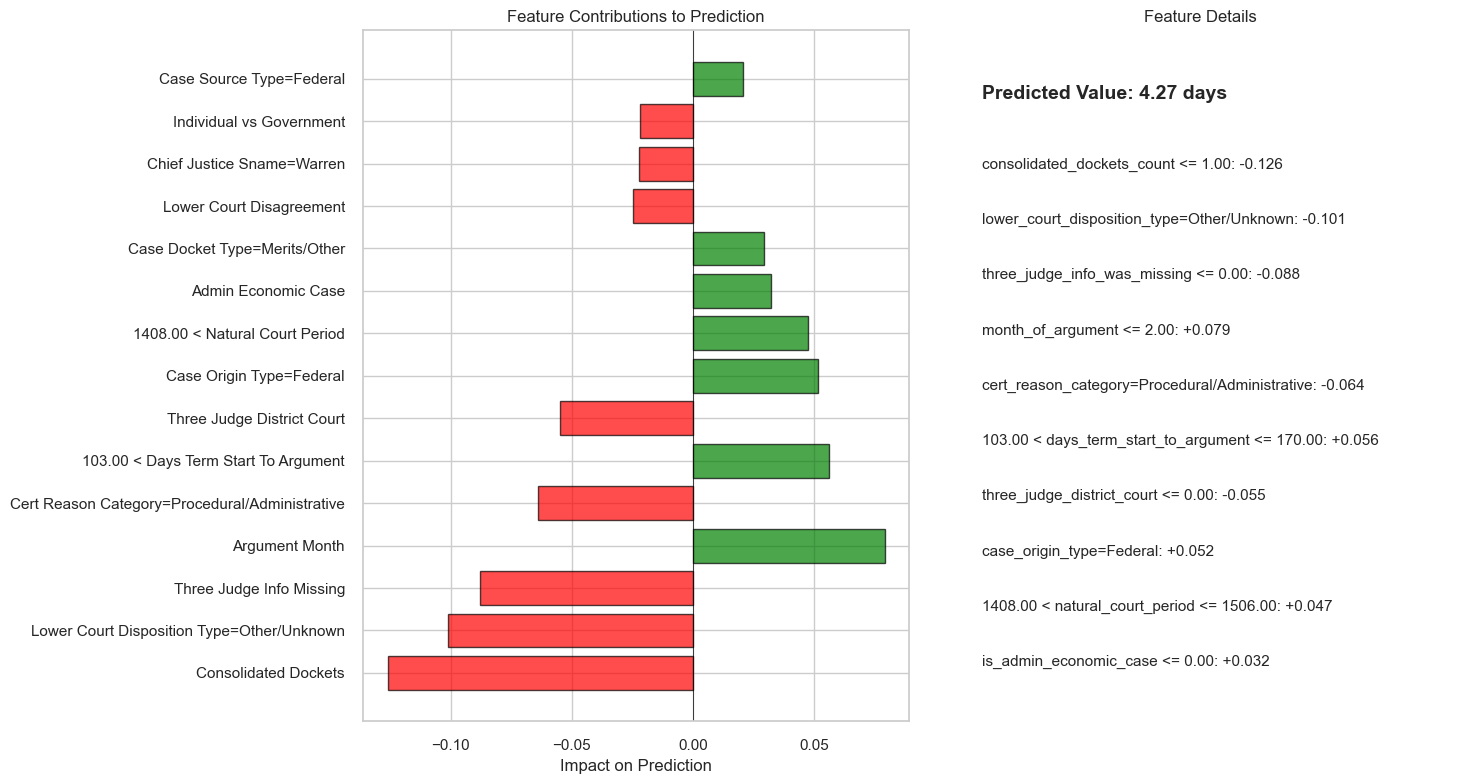

  Enhanced LIME visualizations saved successfully

6. Generating DALEX advanced visualizations...
  Model RMSE: 114.58


Calculating ceteris paribus: 100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


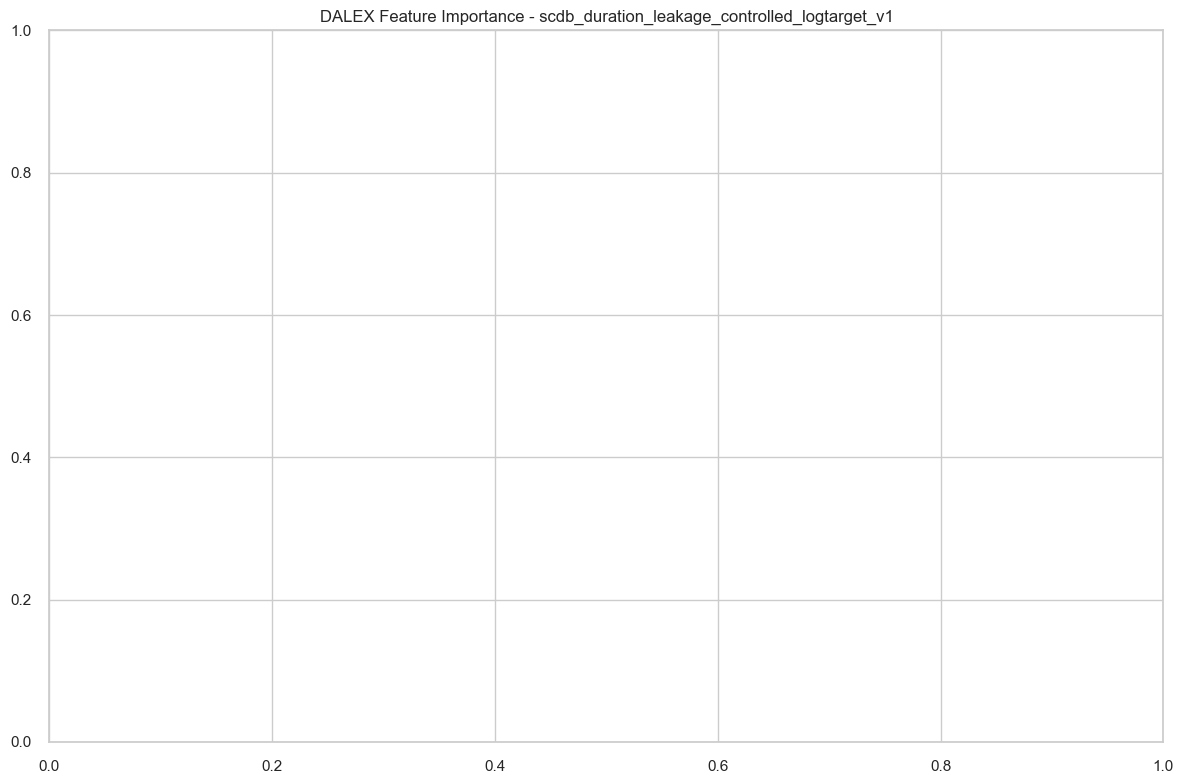

  DALEX visualizations saved successfully

Completed XAI analysis for scdb_duration_leakage_controlled_logtarget_v1

PROCESSING MODEL [3]: scdb_duration_leakage_controlled_optuna_v1

Loading artifacts for 'scdb_duration_leakage_controlled_optuna_v1'...
Successfully loaded model pipeline from: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1.joblib
Successfully loaded Optuna study from: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1_optuna_study.joblib

Recreating data splits...
Recreating splits with params: {'test_size': 0.2, 'eval_size': 0.15, 'random_state_split': 420}, Stratify: True

1. Generating SHAP visualizations...


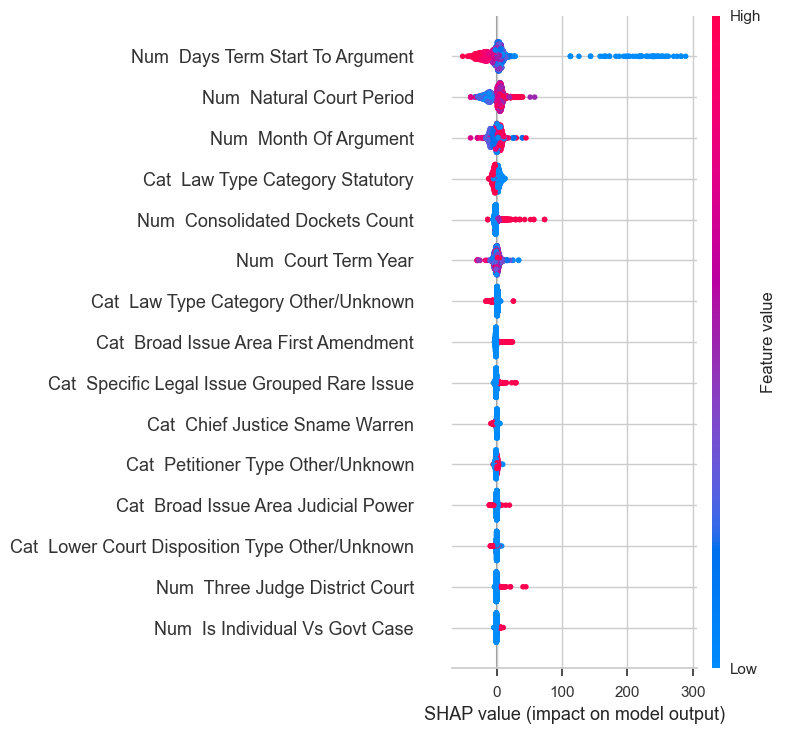

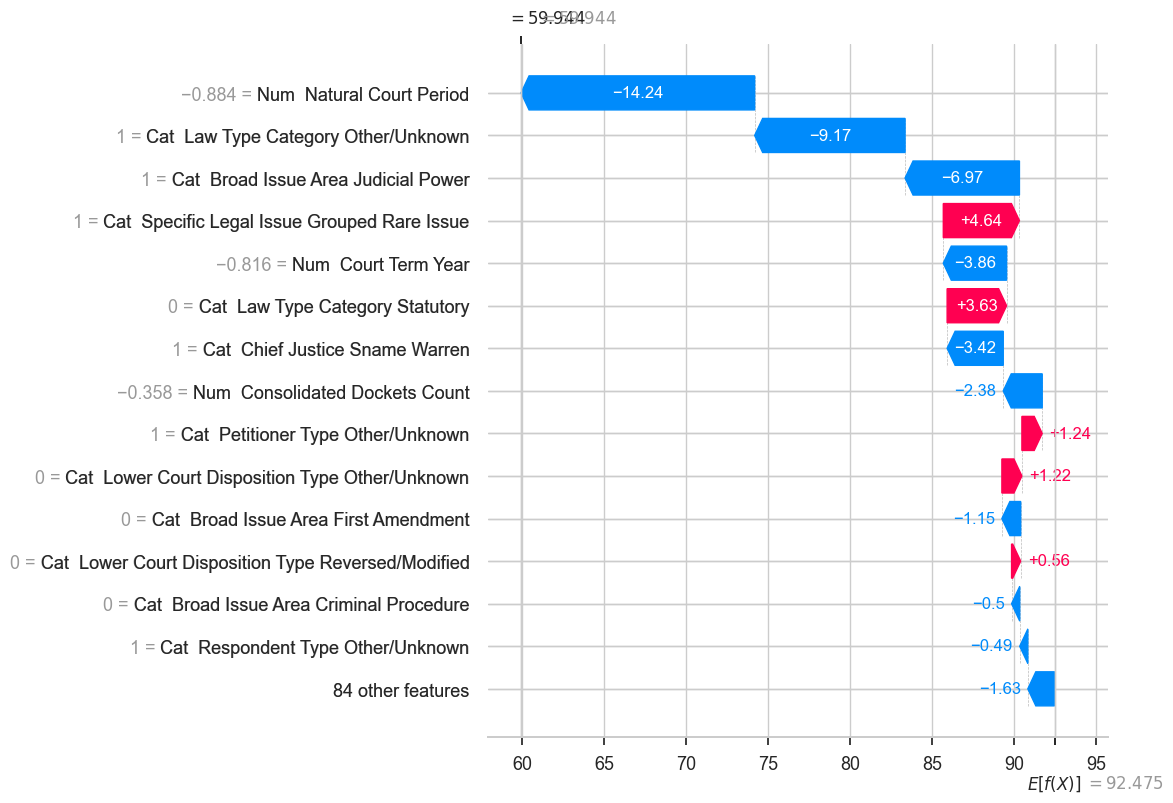

<Figure size 800x550 with 0 Axes>

  SHAP plots saved successfully

2. Generating Partial Dependence Plots...

Generating Partial Dependence Plots...
  PDP plots failed: 'values'

3. Generating ICE Plots...

Generating ICE Plots...
  ICE plots failed: 'values'

4. Generating Error Analysis...

Generating Error Analysis Plots...


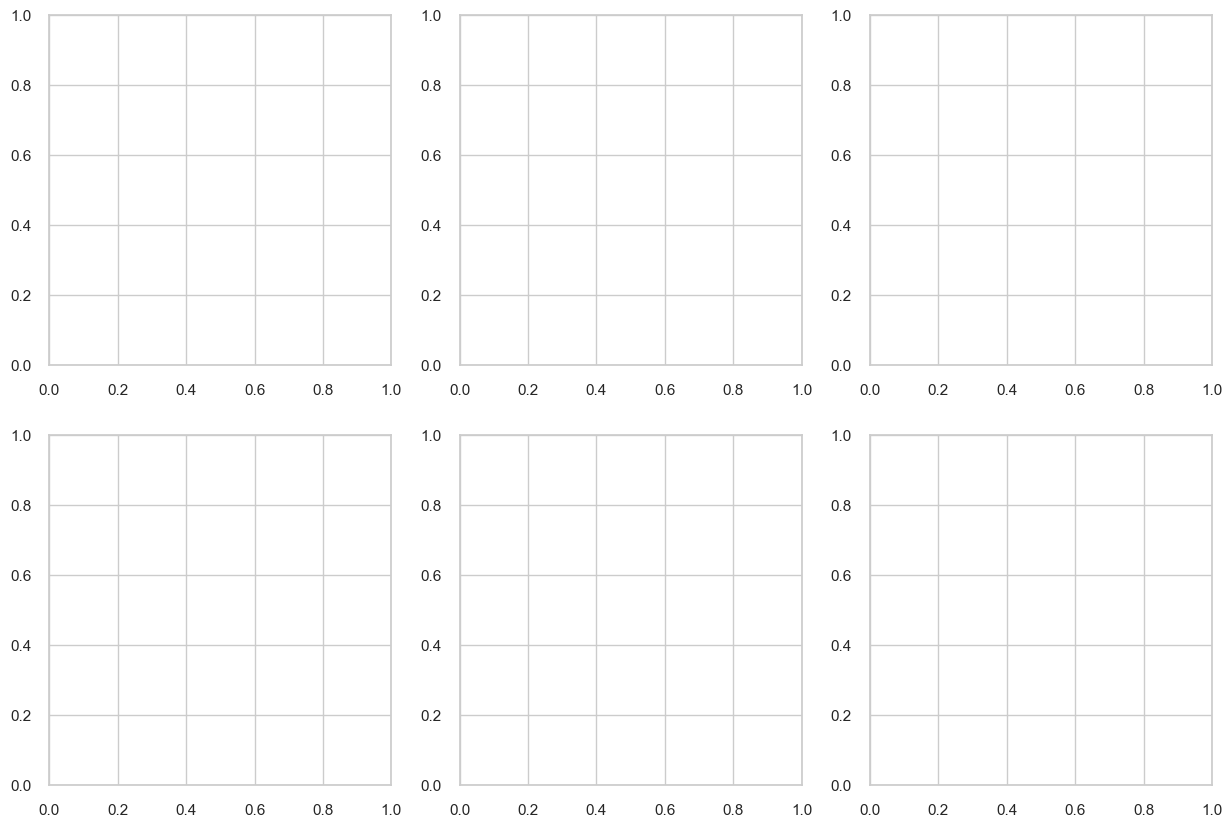

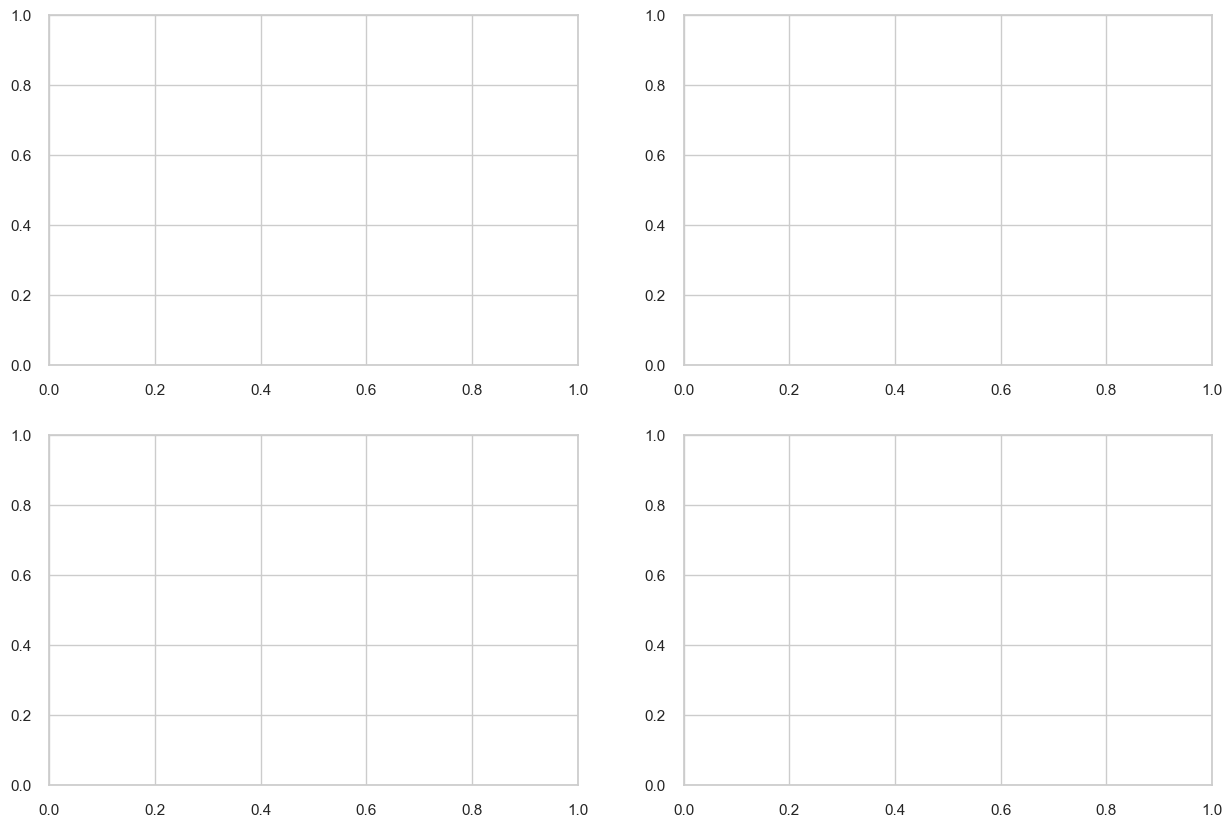

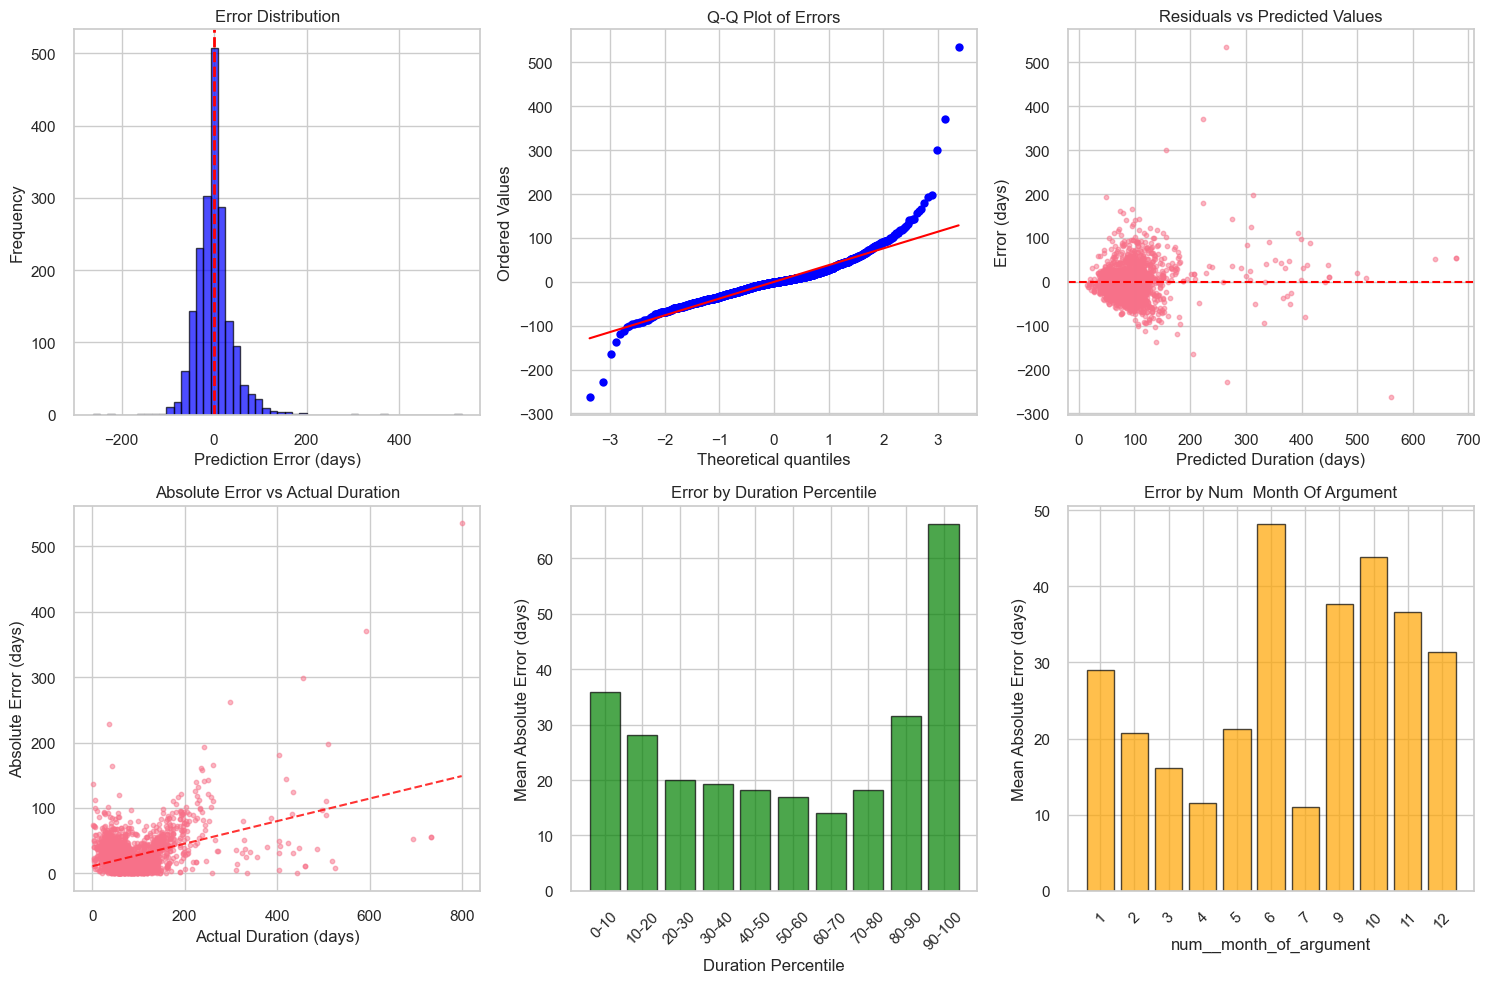

  Error analysis plots saved successfully

5. Generating Enhanced LIME visualization...

Enhancing LIME visualization...


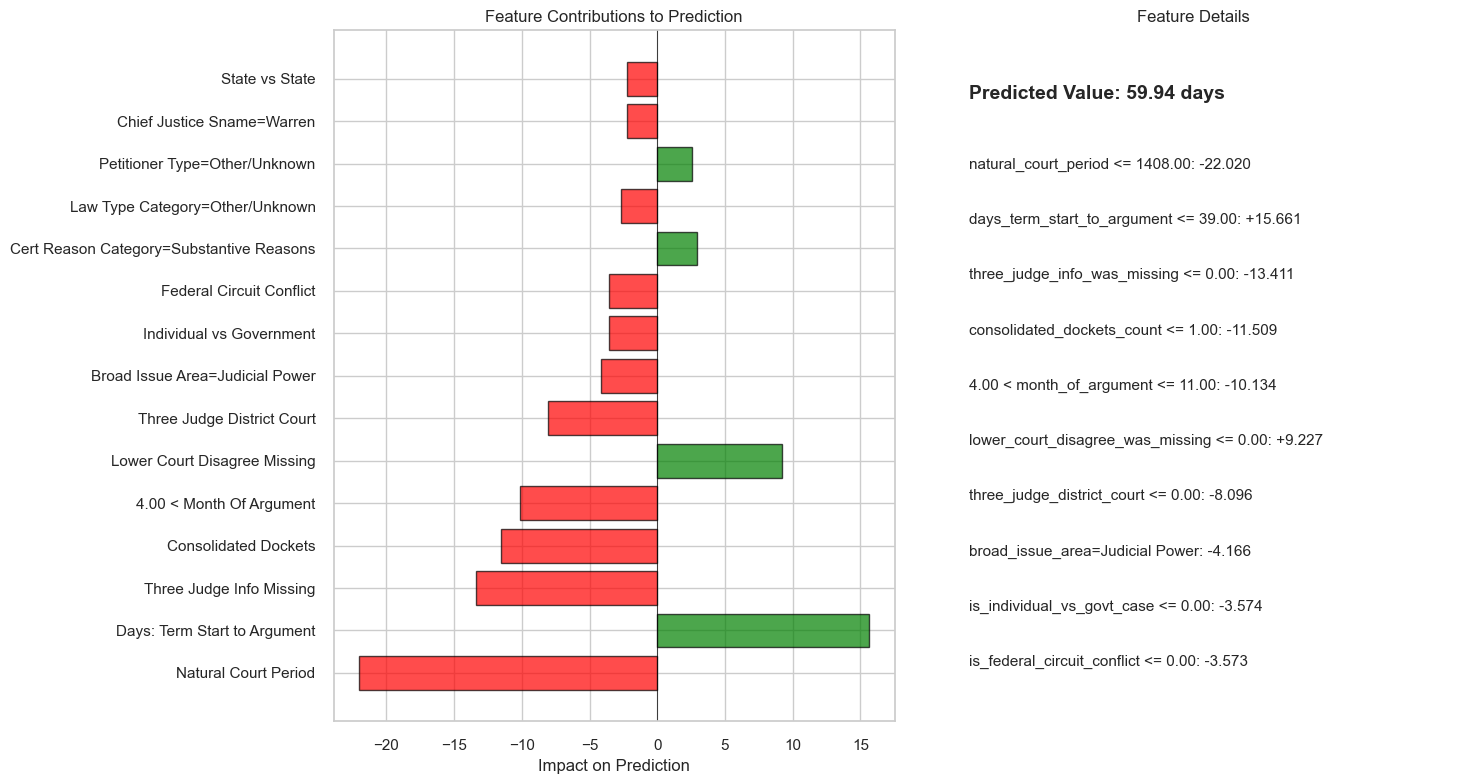


Enhancing LIME visualization...


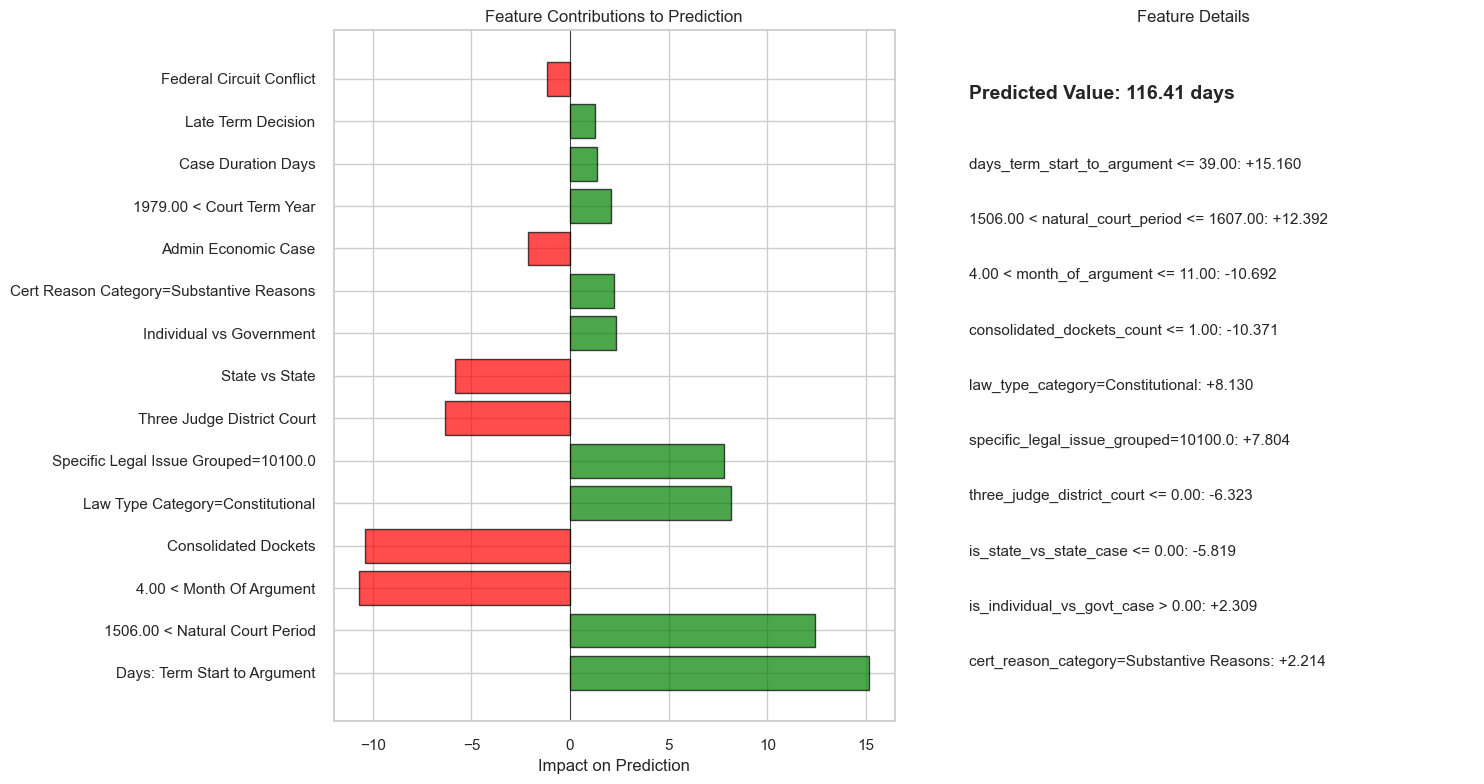


Enhancing LIME visualization...


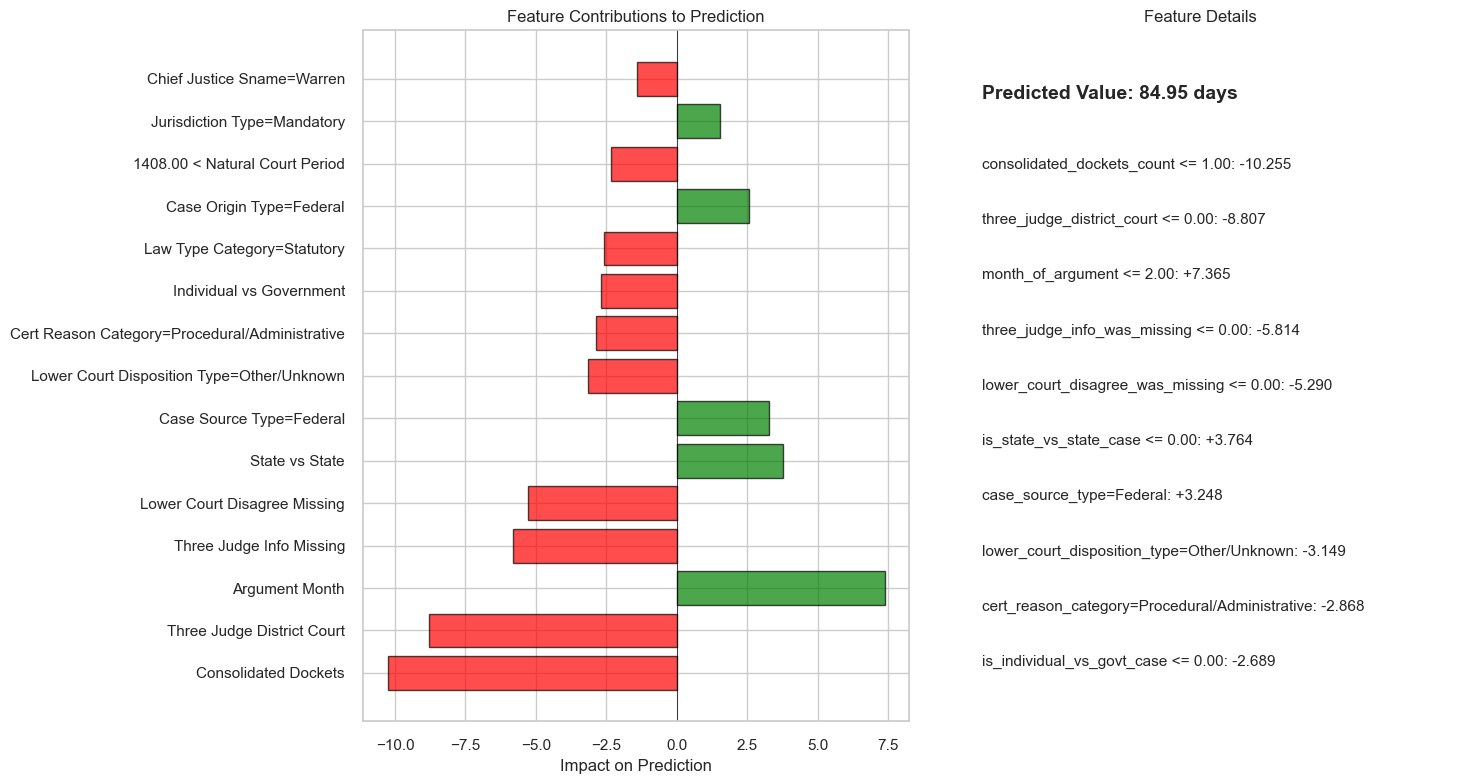

  Enhanced LIME visualizations saved successfully

6. Generating DALEX advanced visualizations...
  Model RMSE: 40.84


Calculating ceteris paribus: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


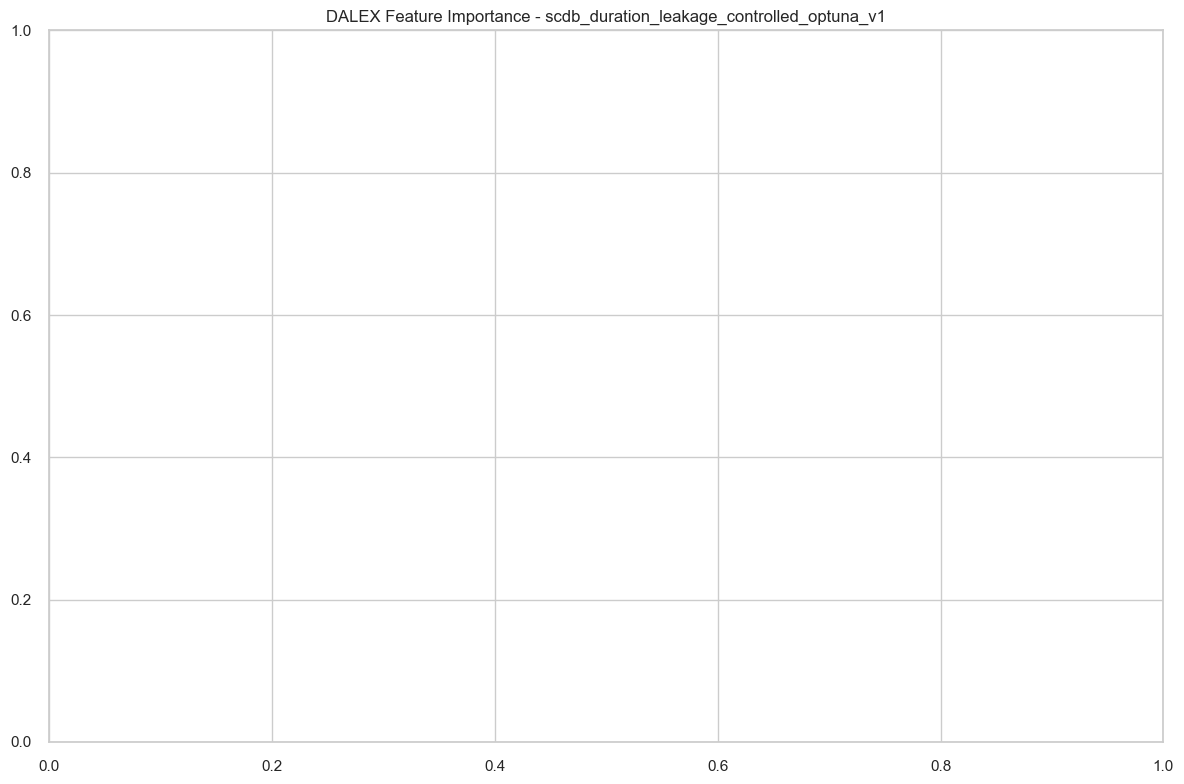

  DALEX visualizations saved successfully

Completed XAI analysis for scdb_duration_leakage_controlled_optuna_v1


MULTI-MODEL XAI ANALYSIS COMPLETED

Generated visualizations include:
1. SHAP summary and waterfall plots
2. Partial Dependence Plots (PDP)
3. Individual Conditional Expectation (ICE) plots
4. Comprehensive error analysis
5. Enhanced LIME explanations
6. DALEX feature importance and model performance


In [14]:
# =============================================================================
# SECTION 5: COMPREHENSIVE XAI ANALYSIS
# =============================================================================
MODEL_INDICES_TO_ANALYZE = [0, 3]  # Adjust as needed

if 'sorted_by_rmse' in locals() and DATA_LOADED:
    for model_index in MODEL_INDICES_TO_ANALYZE:
        if model_index >= len(sorted_by_rmse):
            print(f"\nSkipping index {model_index}: out of bounds.")
            continue

        selected_model_info = sorted_by_rmse[model_index]
        model_name = selected_model_info['name']
        print("\n" + "="*80)
        print(f"PROCESSING MODEL [{model_index}]: {model_name}")
        print("="*80)

        # Load artifacts
        print(f"\nLoading artifacts for '{model_name}'...")
        loaded_artifacts = load_model_artifacts(selected_model_info['path'])
        
        if not loaded_artifacts:
            print(f"Could not load artifacts for {model_name}. Skipping.")
            continue

        metadata_loaded = loaded_artifacts.get('metadata', {})
        
        # Recreate data splits
        print("\nRecreating data splits...")
        recreated_splits = get_data_splits_from_metadata(df_cleaned, y, metadata_loaded)
        
        if not recreated_splits:
            print(f"Could not recreate data splits. Skipping.")
            continue
            
        X_train_re, X_val_re, X_test_re, y_train_re, y_val_re, y_test_re = recreated_splits
        pipeline_loaded = loaded_artifacts['pipeline']
        xgb_model_loaded = loaded_artifacts['xgb_model']
        preprocessor_loaded = loaded_artifacts['preprocessor']
        
        # Setup directories
        model_specific_plots_dir = os.path.join(selected_model_info['path'], 'plots')
        main_plots_dir = "../plots"
        os.makedirs(main_plots_dir, exist_ok=True)
        os.makedirs(model_specific_plots_dir, exist_ok=True)
        
        # Get feature names
        feature_names_processed = preprocessor_loaded.get_feature_names_out()
        X_test_processed_df = pd.DataFrame(
            preprocessor_loaded.transform(X_test_re), 
            columns=feature_names_processed
        )
        
        # Make predictions
        y_pred = pipeline_loaded.predict(X_test_re)
        
        # --- 1. SHAP Analysis ---
        try:
            print("\n1. Generating SHAP visualizations...")
            shap_explainer = shap.TreeExplainer(xgb_model_loaded)
            shap_values = shap_explainer.shap_values(X_test_processed_df)
            
            # Summary plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test_processed_df, 
                            feature_names=[get_readable_feature_name(f) for f in feature_names_processed],
                            max_display=15, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(model_specific_plots_dir, 'shap_summary.png'), dpi=300)
            plt.savefig(os.path.join(main_plots_dir, f'{model_name}_shap_summary.png'), dpi=300)
            plt.show()
            plt.close()
            
            # Waterfall plot
            plt.figure(figsize=(10, 8))
            shap.waterfall_plot(
                shap.Explanation(
                    values=shap_values[0],
                    base_values=shap_explainer.expected_value,
                    data=X_test_processed_df.iloc[0].values,
                    feature_names=[get_readable_feature_name(f) for f in feature_names_processed]
                ),
                max_display=15
            )
            plt.tight_layout()
            plt.savefig(os.path.join(model_specific_plots_dir, 'shap_waterfall.png'), dpi=300)
            plt.savefig(os.path.join(main_plots_dir, f'{model_name}_shap_waterfall.png'), dpi=300)
            plt.show()
            plt.close()
            
            print("  SHAP plots saved successfully")
        except Exception as e:
            print(f"  SHAP analysis failed: {e}")
        
        # --- 2. Partial Dependence Plots ---
        try:
            print("\n2. Generating Partial Dependence Plots...")
            pdp_fig = create_pdp_plots(pipeline_loaded, X_test_re, feature_names_processed)
            pdp_fig.savefig(os.path.join(model_specific_plots_dir, 'pdp_plots.png'), dpi=300)
            pdp_fig.savefig(os.path.join(main_plots_dir, f'{model_name}_pdp_plots.png'), dpi=300)
            plt.show()
            plt.close()
            print("  PDP plots saved successfully")
        except Exception as e:
            print(f"  PDP plots failed: {e}")
        
        # --- 3. ICE Plots ---
        try:
            print("\n3. Generating ICE Plots...")
            ice_fig = create_ice_plots(pipeline_loaded, X_test_re, X_test_re, feature_names_processed)
            ice_fig.savefig(os.path.join(model_specific_plots_dir, 'ice_plots.png'), dpi=300)
            ice_fig.savefig(os.path.join(main_plots_dir, f'{model_name}_ice_plots.png'), dpi=300)
            plt.show()
            plt.close()
            print("  ICE plots saved successfully")
        except Exception as e:
            print(f"  ICE plots failed: {e}")
        
        # --- 4. Error Analysis ---
        try:
            print("\n4. Generating Error Analysis...")
            error_fig = create_error_analysis_plots(y_test_re, y_pred, X_test_re, feature_names_processed)
            error_fig.savefig(os.path.join(model_specific_plots_dir, 'error_analysis.png'), dpi=300)
            error_fig.savefig(os.path.join(main_plots_dir, f'{model_name}_error_analysis.png'), dpi=300)
            plt.show()
            plt.close()
            print("  Error analysis plots saved successfully")
        except Exception as e:
            print(f"  Error analysis failed: {e}")
        
        # --- 5. Enhanced LIME ---
        try:
            print("\n5. Generating Enhanced LIME visualization...")
            # Prepare data for LIME
            categorical_features_in_model = [col for col in X_train_re.columns if X_train_re[col].dtype.name in ['category', 'object']]
            
            X_train_lime = X_train_re.copy()
            X_test_lime = X_test_re.copy()
            
            # Encode categorical features
            label_encoders = {}
            for cat_col in categorical_features_in_model:
                le = LabelEncoder()
                combined_cats = pd.concat([X_train_lime[cat_col], X_test_lime[cat_col]], axis=0)
                le.fit(combined_cats.astype(str))
                X_train_lime[cat_col] = le.transform(X_train_lime[cat_col].astype(str))
                X_test_lime[cat_col] = le.transform(X_test_lime[cat_col].astype(str))
                label_encoders[cat_col] = le
            
            categorical_indices = [X_train_lime.columns.get_loc(col) for col in categorical_features_in_model]
            categorical_names = {}
            for idx, col in enumerate(categorical_features_in_model):
                col_idx = X_train_lime.columns.get_loc(col)
                categorical_names[col_idx] = [str(cls) for cls in label_encoders[col].classes_]
            
            lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=X_train_lime.values,
                feature_names=X_train_lime.columns.tolist(),
                categorical_features=categorical_indices,
                categorical_names=categorical_names,
                mode='regression',
                verbose=False
            )
            
            def predict_fn_lime(x):
                x_df = pd.DataFrame(x, columns=X_train_lime.columns)
                x_decoded = x_df.copy()
                for col in categorical_features_in_model:
                    x_decoded[col] = label_encoders[col].inverse_transform(x_df[col].astype(int))
                return pipeline_loaded.predict(x_decoded)
            
            # Explain multiple instances
            for i in range(min(3, len(X_test_lime))):
                lime_exp = lime_explainer.explain_instance(
                    X_test_lime.iloc[i].values, 
                    predict_fn_lime, 
                    num_features=15
                )
                
                # Enhanced visualization
                lime_fig = enhance_lime_visualization(
                    lime_exp, 
                    X_train_lime.columns,
                    save_path=os.path.join(model_specific_plots_dir, f'lime_enhanced_instance_{i}.png')
                )
                plt.show()
                plt.close()
                
                # Save standard HTML
                lime_exp.save_to_file(os.path.join(model_specific_plots_dir, f'lime_explanation_instance_{i}.html'))
            
            print("  Enhanced LIME visualizations saved successfully")
        except Exception as e:
            print(f"  LIME visualization failed: {e}")
        
        # --- 6. DALEX Advanced Analysis ---
        try:
            print("\n6. Generating DALEX advanced visualizations...")
            dalex_explainer = dx.Explainer(pipeline_loaded, data=X_test_re, y=y_test_re, 
                                         label=model_name, verbose=False)
            
            # Feature importance
            pfi = dalex_explainer.model_parts()
            
            # Model performance
            mp = dalex_explainer.model_performance()
            print(f"  Model RMSE: {mp.result['rmse'][0]:.2f}")
            
            # Aggregated profiles
            ap = dalex_explainer.model_profile(type='partial', N=1000)
            
            # Create visualization
            fig, _ = plt.subplots(figsize=(12, 8))
            pfi.plot(max_vars=15, show=False)
            plt.title(f'DALEX Feature Importance - {model_name}')
            plt.tight_layout()
            plt.savefig(os.path.join(model_specific_plots_dir, 'dalex_feature_importance.png'), dpi=300)
            plt.savefig(os.path.join(main_plots_dir, f'{model_name}_dalex_feature_importance.png'), dpi=300)
            plt.show()
            plt.close()
            
            print("  DALEX visualizations saved successfully")
        except Exception as e:
            print(f"  DALEX analysis failed: {e}")
        
        print(f"\nCompleted XAI analysis for {model_name}")
        print("="*80)

    print("\n\nMULTI-MODEL XAI ANALYSIS COMPLETED")
    print("="*80)
    
    # Summary
    print("\nGenerated visualizations include:")
    print("1. SHAP summary and waterfall plots")
    print("2. Partial Dependence Plots (PDP)")
    print("3. Individual Conditional Expectation (ICE) plots")
    print("4. Comprehensive error analysis")
    print("5. Enhanced LIME explanations")
    print("6. DALEX feature importance and model performance")
    
else:
    print("\nSkipping analysis - no models found or data not loaded.")

In [15]:
def create_optuna_visualizations(study, model_name, save_dir):
    """Create comprehensive Optuna study visualizations"""
    print("\nGenerating Optuna visualizations...")
    
    try:
        # 1. Optimization History
        fig_history = vis.plot_optimization_history(study)
        fig_history.update_layout(title=f'Optimization History - {model_name}')
        fig_history.write_image(os.path.join(save_dir, 'optuna_history.png'))
        fig_history.write_html(os.path.join(save_dir, 'optuna_history.html'))
        
        # 2. Parameter Importance
        fig_importance = vis.plot_param_importances(study)
        fig_importance.update_layout(title=f'Parameter Importance - {model_name}')
        fig_importance.write_image(os.path.join(save_dir, 'optuna_param_importance.png'))
        
        # 3. Parallel Coordinate Plot
        fig_parallel = vis.plot_parallel_coordinate(study)
        fig_parallel.update_layout(title=f'Parallel Coordinates - {model_name}')
        fig_parallel.write_image(os.path.join(save_dir, 'optuna_parallel.png'))
        
        # 4. Slice Plot
        fig_slice = vis.plot_slice(study)
        fig_slice.update_layout(title=f'Parameter Slices - {model_name}')
        fig_slice.write_image(os.path.join(save_dir, 'optuna_slice.png'))
        
        # 5. Contour Plot for top 2 parameters
        fig_contour = vis.plot_contour(study)
        fig_contour.update_layout(title=f'Parameter Contours - {model_name}')
        fig_contour.write_image(os.path.join(save_dir, 'optuna_contour.png'))
        
        # 6. EDF (Empirical Distribution Function)
        fig_edf = vis.plot_edf(study)
        fig_edf.update_layout(title=f'Empirical Distribution Function - {model_name}')
        fig_edf.write_image(os.path.join(save_dir, 'optuna_edf.png'))
        
        # 7. Timeline Plot
        fig_timeline = vis.plot_timeline(study)
        fig_timeline.update_layout(title=f'Optimization Timeline - {model_name}')
        fig_timeline.write_image(os.path.join(save_dir, 'optuna_timeline.png'))
        
        print("  All Optuna visualizations saved successfully")
        
    except Exception as e:
        print(f"  Some Optuna visualizations failed: {e}")

In [16]:
# =============================================================================
# SECTION 6: OPTUNA STUDY VISUALIZATION (for a specific model)
# =============================================================================
# Select the model you want to analyze (e.g., the best one, at index 0)
MODEL_INDEX_FOR_OPTUNA = 0

print("\n" + "="*80)
print(f"GENERATING OPTUNA VISUALIZATIONS FOR MODEL [{MODEL_INDEX_FOR_OPTUNA}]")
print("="*80)

if 'sorted_by_rmse' in locals() and MODEL_INDEX_FOR_OPTUNA < len(sorted_by_rmse):
    # Get the model's info
    optuna_model_info = sorted_by_rmse[MODEL_INDEX_FOR_OPTUNA]
    model_name = optuna_model_info['name']
    
    print(f"\nLoading artifacts for '{model_name}'...")
    loaded_artifacts = load_model_artifacts(optuna_model_info['path'])
    
    # Check if a study object was loaded
    if loaded_artifacts and 'optuna_study' in loaded_artifacts:
        study = loaded_artifacts['optuna_study']
        print(f"Found Optuna study with {len(study.trials)} trials.")
        
        # Define where to save the plots
        save_directory = os.path.join(optuna_model_info['path'], 'plots')

        # Generate the visualizations using the function from your notebook
        # Make sure the 'create_optuna_visualizations' function is defined in your notebook
        create_optuna_visualizations(
            study=study,
            model_name=model_name,
            save_dir=save_directory
        )
    else:
        print(f"No Optuna study found for model '{model_name}'. "
              "This is expected if the model was not trained with 'optuna'.")
else:
    print("Skipping Optuna visualization - no models found or index out of bounds.")


GENERATING OPTUNA VISUALIZATIONS FOR MODEL [0]

Loading artifacts for 'scdb_duration_leakage_controlled_logtarget_v1'...
Successfully loaded model pipeline from: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1.joblib
Successfully loaded Optuna study from: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna_study.joblib
Found Optuna study with 100 trials.

Generating Optuna visualizations...
  All Optuna visualizations saved successfully


## 7. Results 